# Whisper Attention Analysis

Analyzing attention patterns in Whisper-tiny to understand head specialization across:
1. **Encoder self-attention**: Acoustic/phonetic processing
2. **Decoder cross-attention**: Audio-text alignment
3. **Decoder self-attention**: Linguistic/sequential patterns

**Encoder Metrics:**
- **Locality**: How local/diagonal is attention (1=diagonal, 0.5=spread)
- **Speech Retention**: Fraction of speech queries' attention staying in speech region
- **Energy Correlation**: Correlation between attention received and mel energy

**Decoder Cross-Attention Metrics:**
- **Speech Focus**: Fraction of attention within speech region vs padding
- **Sharpness**: How peaked the attention distribution is (alignment precision)
- **Monotonicity**: Left-to-right progression (temporal alignment)

**Decoder Self-Attention Metrics:**
- **BOS Attention**: Attention to start-of-sequence token
- **Previous Token**: Attention to immediately preceding token
- **Recency Bias**: Bias toward recent vs distant tokens

In [1]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import io
from dataclasses import dataclass

from transformers import WhisperForConditionalGeneration, WhisperProcessor
import datasets as ds

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
%load_ext autoreload
%autoreload 2


Device: mps


In [2]:
# Load Whisper with eager attention (required for attention output)
model_name = 'openai/whisper-tiny'
model = WhisperForConditionalGeneration.from_pretrained(
    model_name,
    attn_implementation='eager',  # Required to get attention weights
).to(device)
processor = WhisperProcessor.from_pretrained(model_name)
model.eval()

print(f'Model: {model_name}')
print(f'Encoder layers: {model.config.encoder_layers}')
print(f'Decoder layers: {model.config.decoder_layers}')
print(f'Hidden dim: {model.config.d_model}')

Model: openai/whisper-tiny
Encoder layers: 4
Decoder layers: 4
Hidden dim: 384


In [3]:
# Load LibriSpeech - disable audio decoding to avoid torchcodec issues
N_LOAD = 60  # Load enough for analysis

dataset = ds.load_dataset(
    'librispeech_asr',
    'clean', 
    split='validation',
    streaming=True,
).cast_column('audio', ds.Audio(decode=False))

raw_samples = list(dataset.take(N_LOAD))

# Decode with soundfile
samples = []
for raw in raw_samples:
    audio_bytes = raw['audio']['bytes']
    audio_array, sr = sf.read(io.BytesIO(audio_bytes))
    samples.append({
        'audio': {'array': audio_array, 'sampling_rate': sr},
        'text': raw['text'],
    })

print(f'Loaded {len(samples)} samples')
print(f'First 5:')
for i, s in enumerate(samples[:5]):
    print(f'  {i}: "{s["text"][:50]}..."')

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Loaded 60 samples
First 5:
  0: "HE WAS IN A FEVERED STATE OF MIND OWING TO THE BLI..."
  1: "HE WOULD HAVE TO PAY HER THE MONEY WHICH SHE WOULD..."
  2: "HURSTWOOD WALKED THE FLOOR MENTALLY ARRANGING THE ..."
  3: "HE ALSO THOUGHT OF HIS MANAGERIAL POSITION..."
  4: "HOW WOULD THE PAPERS TALK ABOUT IT..."


In [4]:
def process_audio(sample):
    """Process audio to Whisper input features."""
    audio = sample['audio']['array']
    sr = sample['audio']['sampling_rate']
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(sr, 16000)
        audio = resampler(torch.from_numpy(audio).float()).numpy()
    inputs = processor(audio, sampling_rate=16000, return_tensors='pt')
    return inputs.input_features.to(device)

# Process first sample
input_features = process_audio(samples[0])
ground_truth = samples[0]['text']
print(f'Input shape: {input_features.shape}')
print(f'Ground truth: "{ground_truth}"')

Input shape: torch.Size([1, 80, 3000])
Ground truth: "HE WAS IN A FEVERED STATE OF MIND OWING TO THE BLIGHT HIS WIFE'S ACTION THREATENED TO CAST UPON HIS ENTIRE FUTURE"


In [5]:
# Generate transcription and get encoder outputs
with torch.no_grad():
    generated = model.generate(input_features, max_new_tokens=128)
    encoder_outputs = model.model.encoder(
        input_features,
        output_hidden_states=True,
        output_attentions=True,
        return_dict=True,
    )

generated_text = processor.batch_decode(generated, skip_special_tokens=True)[0]
print(f'Generated: "{generated_text}"')
print(f'Ground truth: "{ground_truth}"')

Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated: " He was in a fevered state of mind, owing to the blight his wife's action threatened to cast upon his entire future."
Ground truth: "HE WAS IN A FEVERED STATE OF MIND OWING TO THE BLIGHT HIS WIFE'S ACTION THREATENED TO CAST UPON HIS ENTIRE FUTURE"


## 1. Encoder Self-Attention Analysis

Analyzing attention patterns across multiple samples to identify **head specialization**:
- **Local heads**: Attend to nearby positions (diagonal pattern)
- **Broadcast heads**: Uniform attention to specific positions (vertical stripes)
- **Energy-correlated heads**: Attend preferentially to speech vs silence

Key metrics:
- **Locality score**: How close to diagonal (1=local, 0.5=spread)
- **Uniformity score**: Entropy of attention distribution (1=uniform broadcast)
- **Energy correlation**: Correlation between attention received and mel energy (+speech, -silence)

In [6]:
# Encoder self-attention analysis across multiple samples
# Whisper encoder: 3000 mel frames -> 1500 positions (2x downsampling from conv layers)
# 3000 mel frames = 30 seconds, so 1500 positions = 30 seconds
# Each position = 20ms

N_SAMPLES = 50  # Number of samples to analyze
MS_PER_POSITION = 20  # Time resolution

print(f"Analyzing encoder attention across {N_SAMPLES} samples...")
print(f"Time resolution: {MS_PER_POSITION}ms per position")

# Collect attention patterns and mel energies from multiple samples
all_attention_patterns = []
all_mel_energies = []
sample_lengths = []

for i, sample in enumerate(samples[:N_SAMPLES]):
    if i % 10 == 0:
        print(f"  Processing sample {i+1}/{N_SAMPLES}...")
    
    input_feats = process_audio(sample)
    
    with torch.no_grad():
        enc_out = model.model.encoder(
            input_feats,
            output_attentions=True,
            return_dict=True,
        )
    
    # Stack attention from all layers: [4, 6, 1500, 1500]
    attn_stack = torch.stack([a[0] for a in enc_out.attentions])
    all_attention_patterns.append(attn_stack.cpu())
    
    # Get mel energy per position
    mel_energy = input_feats[0].mean(dim=0).cpu().numpy()  # [3000]
    mel_energy_down = mel_energy.reshape(1500, 2).mean(axis=1)  # [1500]
    all_mel_energies.append(mel_energy_down)
    sample_lengths.append(len(sample['audio']['array']) / sample['audio']['sampling_rate'])

# Compute mean attention pattern
mean_attn = torch.stack(all_attention_patterns).mean(dim=0)  # [4, 6, 1500, 1500]
n_layers, n_heads = mean_attn.shape[0], mean_attn.shape[1]
seq_len = mean_attn.shape[2]

# Compute audio frame counts for each sample (needed for speech_mass metric)
durations = np.array(sample_lengths)
audio_frames = (durations / 0.02).astype(int)  # 20ms per frame
audio_frames = np.clip(audio_frames, 0, 1500)

print(f"\nMean attention shape: {mean_attn.shape}")
print(f"Sample durations: {np.mean(sample_lengths):.1f}s +/- {np.std(sample_lengths):.1f}s")
print(f"Audio frames: {np.mean(audio_frames):.0f} +/- {np.std(audio_frames):.0f} / 1500 ({np.mean(audio_frames)/1500*100:.0f}% speech)")

Analyzing encoder attention across 50 samples...
Time resolution: 20ms per position
  Processing sample 1/50...
  Processing sample 11/50...
  Processing sample 21/50...
  Processing sample 31/50...
  Processing sample 41/50...

Mean attention shape: torch.Size([4, 6, 1500, 1500])
Sample durations: 4.6s +/- 1.9s
Audio frames: 232 +/- 94 / 1500 (15% speech)


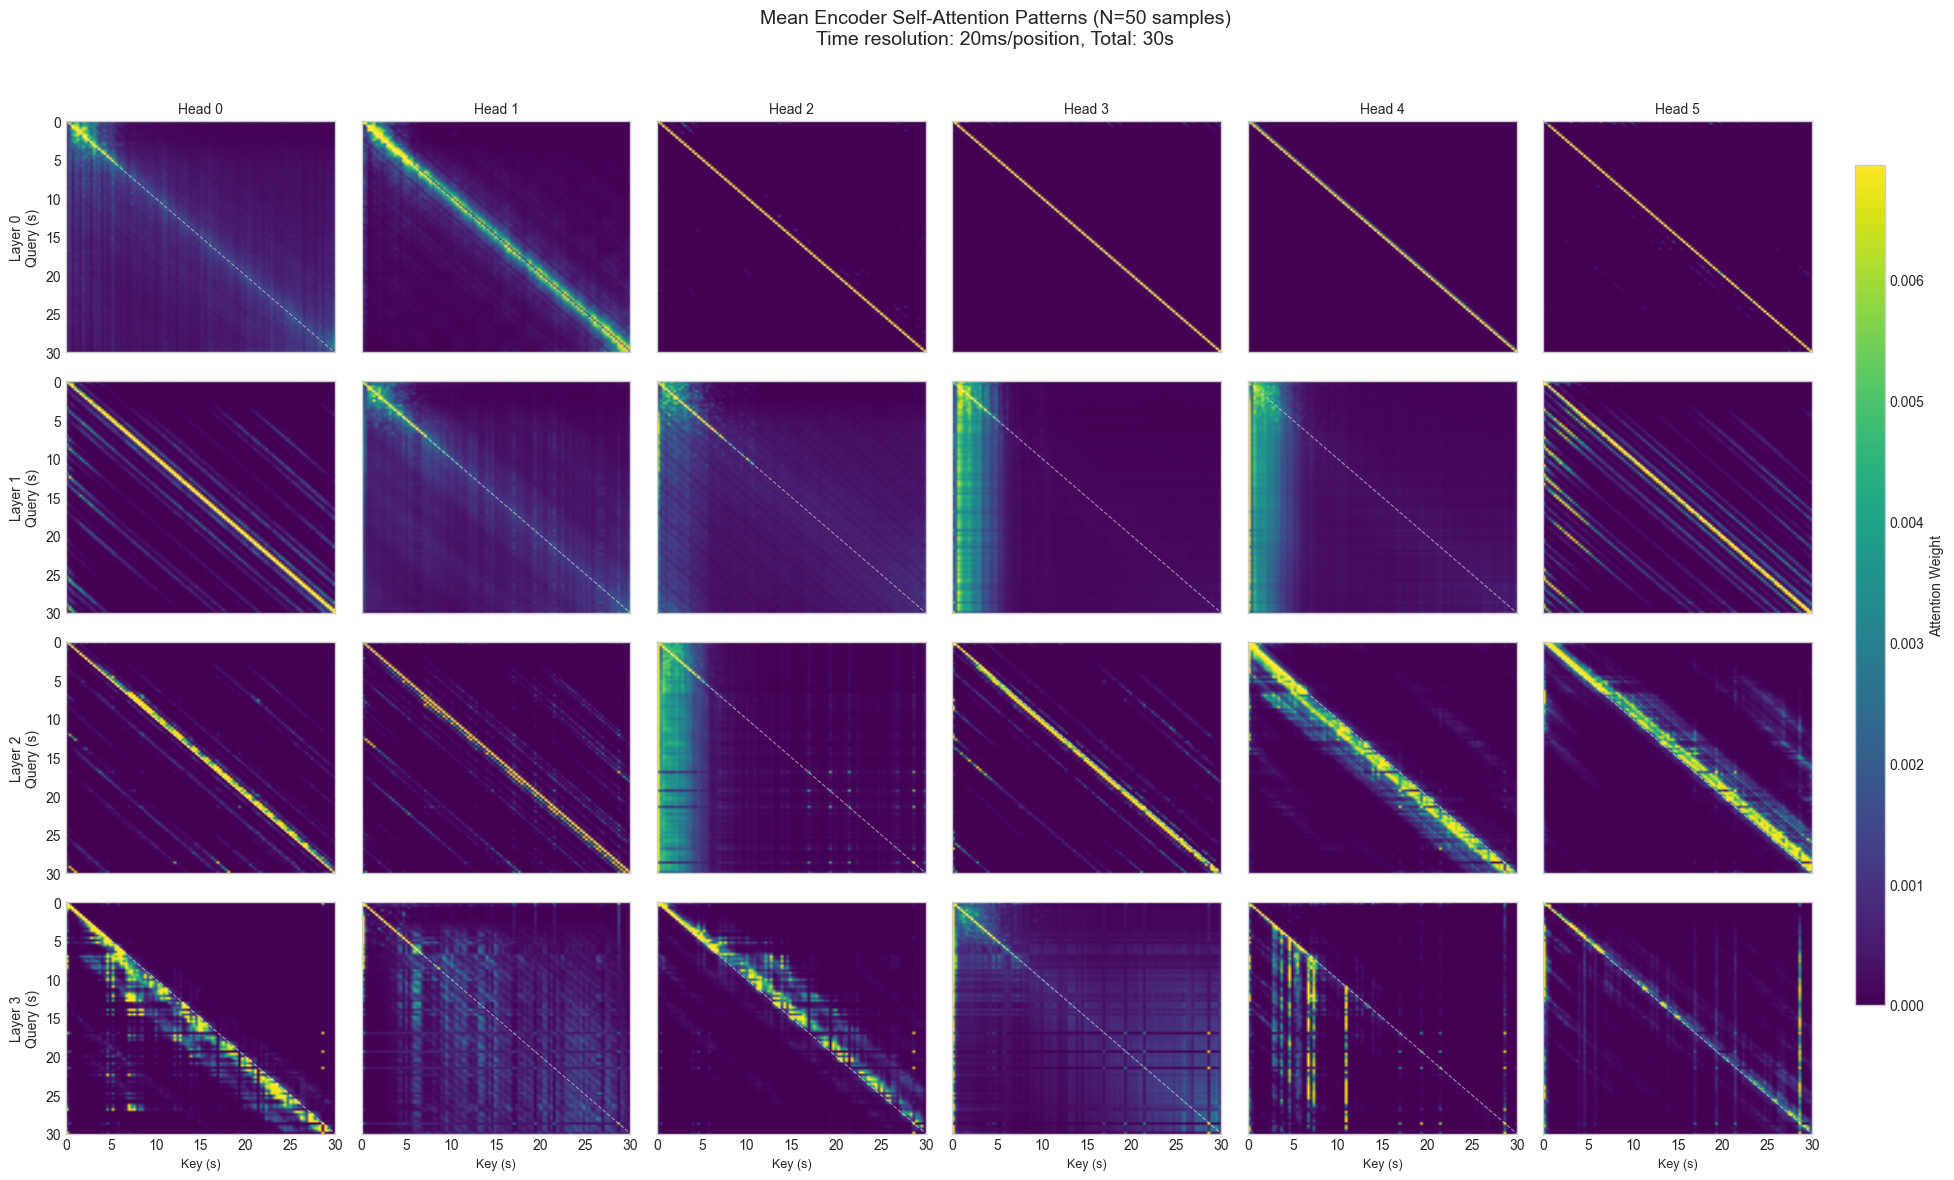

Attention clipped at 99th percentile: 0.0069


In [7]:
# Plot mean attention patterns (averaged over N samples)
# Visual improvements: colorbar, better contrast, diagonal reference

step = 15  # Subsample for visualization
time_extent = seq_len * MS_PER_POSITION / 1000  # Total time in seconds

# Compute 99th percentile for better contrast (clip outliers)
vmax = np.percentile(mean_attn.numpy(), 99)

# Create figure with extra space on right for colorbar
fig, axes = plt.subplots(n_layers, n_heads, figsize=(20, 12))
fig.suptitle(f'Mean Encoder Self-Attention Patterns (N={N_SAMPLES} samples)\n'
             f'Time resolution: {MS_PER_POSITION}ms/position, Total: {time_extent:.0f}s', fontsize=14)

for l in range(n_layers):
    for h in range(n_heads):
        ax = axes[l, h]
        attn_sub = mean_attn[l, h, ::step, ::step].numpy()
        
        # Use viridis for better visibility of faint patterns, clip to 99th percentile
        im = ax.imshow(attn_sub, cmap='viridis', aspect='auto',
                       extent=[0, time_extent, time_extent, 0],
                       interpolation='bilinear',
                       vmin=0, vmax=vmax)
        
        # Add diagonal reference line (white for visibility against viridis)
        ax.plot([0, time_extent], [0, time_extent], 'w--', alpha=0.5, linewidth=0.8)
        
        if l == 0:
            ax.set_title(f'Head {h}', fontsize=10)
        if h == 0:
            ax.set_ylabel(f'Layer {l}\nQuery (s)', fontsize=10)
        if l == n_layers - 1:
            ax.set_xlabel('Key (s)', fontsize=9)
        
        # Clean up ticks
        ax.grid(False, which='both')
        ax.minorticks_off()
        ax.tick_params(axis='both', which='both', length=0)
        
        if l != n_layers - 1:
            ax.set_xticklabels([])
        if h != 0:
            ax.set_yticklabels([])

# Adjust layout first, then add colorbar in reserved space
plt.tight_layout(rect=[0, 0, 0.92, 0.96])  # Leave space on right for colorbar

# Add colorbar to the right of all subplots
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Attention Weight', fontsize=10)

plt.savefig('attention_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Attention clipped at 99th percentile: {vmax:.4f}")

Computing attention-energy correlations for each head...


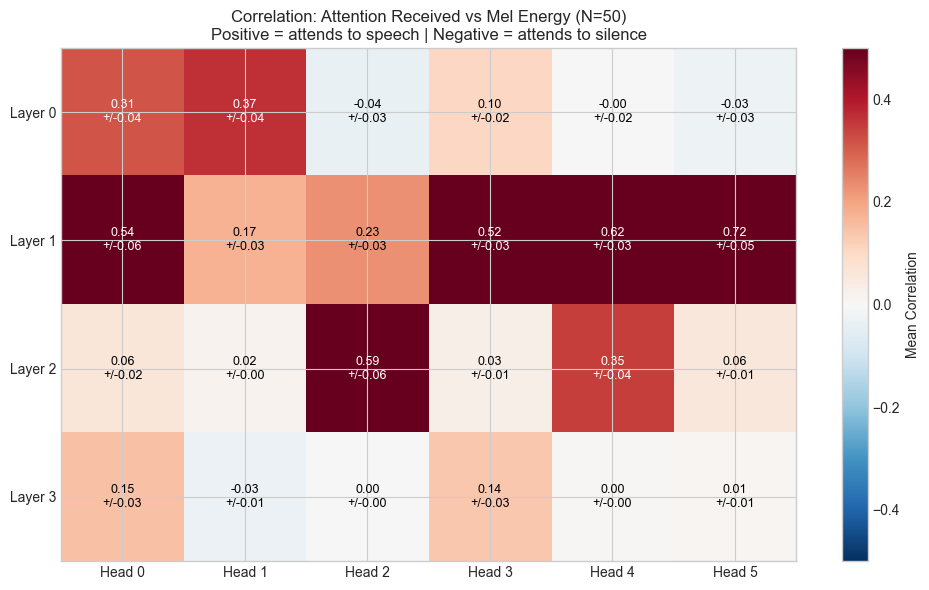


Most correlated heads (attend to speech):
  L1H5: r=0.722 +/- 0.046
  L1H4: r=0.618 +/- 0.033
  L2H2: r=0.595 +/- 0.058

Most anti-correlated heads (attend to silence/pauses):
  L0H2: r=-0.036 +/- 0.029
  L3H1: r=-0.030 +/- 0.015
  L0H5: r=-0.026 +/- 0.027


In [8]:
# Analyze correlation between attention received and mel energy for each head
# This reveals which heads attend to silence vs speech

print("Computing attention-energy correlations for each head...")

# For each sample, compute correlation between "attention received" (column sums) and mel energy
correlations = np.zeros((N_SAMPLES, n_layers, n_heads))

for i in range(N_SAMPLES):
    attn = all_attention_patterns[i]  # [4, 6, 1500, 1500]
    mel_energy = all_mel_energies[i]  # [1500]
    
    for l in range(n_layers):
        for h in range(n_heads):
            # Attention received = how much each position is attended TO (column sum)
            attn_received = attn[l, h].sum(dim=0).numpy()  # [1500]
            corr = np.corrcoef(attn_received, mel_energy)[0, 1]
            correlations[i, l, h] = corr if not np.isnan(corr) else 0

# Compute mean and std across samples
mean_corr = correlations.mean(axis=0)  # [4, 6]
std_corr = correlations.std(axis=0)    # [4, 6]

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(mean_corr, cmap='RdBu_r', vmin=-0.5, vmax=0.5, aspect='auto')

for l in range(n_layers):
    for h in range(n_heads):
        text = f'{mean_corr[l, h]:.2f}\n+/-{std_corr[l, h]:.2f}'
        ax.text(h, l, text, ha='center', va='center', fontsize=9,
                color='white' if abs(mean_corr[l, h]) > 0.25 else 'black')

ax.set_xticks(range(n_heads))
ax.set_xticklabels([f'Head {h}' for h in range(n_heads)])
ax.set_yticks(range(n_layers))
ax.set_yticklabels([f'Layer {l}' for l in range(n_layers)])
ax.set_title(f'Correlation: Attention Received vs Mel Energy (N={N_SAMPLES})\n'
             'Positive = attends to speech | Negative = attends to silence', fontsize=12)
plt.colorbar(im, ax=ax, label='Mean Correlation')
plt.tight_layout()
plt.show()

# Find most interesting heads
print("\nMost correlated heads (attend to speech):")
for idx in np.argsort(mean_corr.flatten())[-3:][::-1]:
    l, h = divmod(idx, n_heads)
    print(f"  L{l}H{h}: r={mean_corr[l, h]:.3f} +/- {std_corr[l, h]:.3f}")

print("\nMost anti-correlated heads (attend to silence/pauses):")
for idx in np.argsort(mean_corr.flatten())[:3]:
    l, h = divmod(idx, n_heads)
    print(f"  L{l}H{h}: r={mean_corr[l, h]:.3f} +/- {std_corr[l, h]:.3f}")

Computing head specialization metrics...


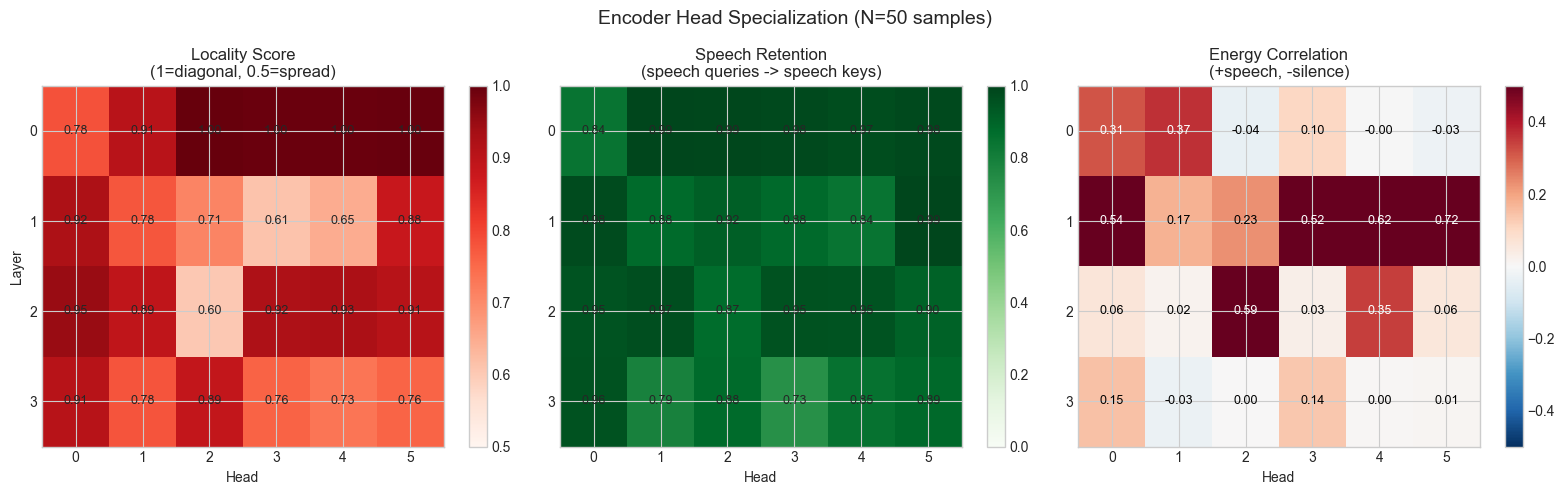


HEAD SPECIALIZATION SUMMARY
Speech retention = fraction of speech queries' attention that stays in speech region
(Expected baseline for local heads: ~n_frames/seq_len, but should be higher if head
 preferentially attends within speech vs leaking to padding)
L0H0: ENERGY-SPEECH                       | loc=0.78, retention=0.84, corr=+0.31
L0H1: LOCAL + ENERGY-SPEECH               | loc=0.91, retention=0.99, corr=+0.37
L0H2: LOCAL                               | loc=1.00, retention=0.99, corr=-0.04
L0H3: LOCAL                               | loc=1.00, retention=0.98, corr=+0.10
L0H4: LOCAL                               | loc=1.00, retention=0.97, corr=-0.00
L0H5: LOCAL                               | loc=1.00, retention=0.98, corr=-0.03
L1H0: LOCAL + ENERGY-SPEECH               | loc=0.92, retention=0.98, corr=+0.54
L1H1: MIXED                               | loc=0.78, retention=0.88, corr=+0.17
L1H2: ENERGY-SPEECH                       | loc=0.71, retention=0.92, corr=+0.23
L1H3: ENERGY

In [9]:
# Compute attention pattern metrics for head specialization analysis
print("Computing head specialization metrics...")

# Precompute distance matrix once (optimization)
positions = torch.arange(seq_len)
distance = (positions.unsqueeze(1) - positions.unsqueeze(0)).abs().float()

# Metrics across all samples
locality_scores = np.zeros((N_SAMPLES, n_layers, n_heads))
speech_retention_scores = np.zeros((N_SAMPLES, n_layers, n_heads))  # speech queries -> speech keys

for i in range(N_SAMPLES):
    attn = all_attention_patterns[i]  # [4, 6, 1500, 1500]
    n_frames = audio_frames[i]  # frames of actual speech
    
    for l in range(n_layers):
        for h in range(n_heads):
            a = attn[l, h]  # [1500, 1500]
            
            # Locality: mean distance from diagonal weighted by attention
            # Normalized by (seq_len - 1) which is the max possible distance
            mean_distance = (a * distance).sum() / a.sum()
            locality_scores[i, l, h] = 1 - (mean_distance / (seq_len - 1)).item()
            
            # Speech retention: what fraction of speech queries' attention stays in speech?
            # This is CONDITIONAL on being a speech query, so it's not dominated by n_frames/seq_len
            # Near 1.0 = speech queries attend within speech
            # Near 0.0 = speech queries leak into padding
            if n_frames > 0:
                speech_rows = a[:n_frames, :]  # attention from speech queries
                speech_to_speech = speech_rows[:, :n_frames].sum()
                speech_retention_scores[i, l, h] = (speech_to_speech / (speech_rows.sum() + 1e-9)).item()

# Average across samples
mean_locality = locality_scores.mean(axis=0)
mean_speech_retention = speech_retention_scores.mean(axis=0)

# Plot head specialization summary (3 panels: locality, speech_retention, correlation)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Locality
im1 = axes[0].imshow(mean_locality, cmap='Reds', aspect='auto', vmin=0.5, vmax=1)
axes[0].set_title('Locality Score\n(1=diagonal, 0.5=spread)')
axes[0].set_xlabel('Head')
axes[0].set_ylabel('Layer')
for l in range(n_layers):
    for h in range(n_heads):
        axes[0].text(h, l, f'{mean_locality[l, h]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im1, ax=axes[0])

# Speech retention (conditional)
im2 = axes[1].imshow(mean_speech_retention, cmap='Greens', aspect='auto', vmin=0, vmax=1)
axes[1].set_title('Speech Retention\n(speech queries -> speech keys)')
axes[1].set_xlabel('Head')
for l in range(n_layers):
    for h in range(n_heads):
        axes[1].text(h, l, f'{mean_speech_retention[l, h]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im2, ax=axes[1])

# Energy correlation (from earlier cell)
im3 = axes[2].imshow(mean_corr, cmap='RdBu_r', aspect='auto', vmin=-0.5, vmax=0.5)
axes[2].set_title('Energy Correlation\n(+speech, -silence)')
axes[2].set_xlabel('Head')
for l in range(n_layers):
    for h in range(n_heads):
        axes[2].text(h, l, f'{mean_corr[l, h]:.2f}', ha='center', va='center', fontsize=9,
                    color='white' if abs(mean_corr[l, h]) > 0.25 else 'black')
plt.colorbar(im3, ax=axes[2])

for ax in axes:
    ax.set_xticks(range(n_heads))
    ax.set_yticks(range(n_layers))

fig.suptitle(f'Encoder Head Specialization (N={N_SAMPLES} samples)', fontsize=14)
plt.tight_layout()
plt.show()

# Print summary with multi-axis classification
print("\n" + "="*70)
print("HEAD SPECIALIZATION SUMMARY")
print("="*70)
print("Speech retention = fraction of speech queries' attention that stays in speech region")
print("(Expected baseline for local heads: ~n_frames/seq_len, but should be higher if head")
print(" preferentially attends within speech vs leaking to padding)")
print("="*70)

for l in range(n_layers):
    for h in range(n_heads):
        loc = mean_locality[l, h]
        sr = mean_speech_retention[l, h]
        corr = mean_corr[l, h]
        
        # Multi-axis classification
        # Note: for a perfectly local head, speech retention should be high
        # Low speech retention (<0.5) means speech queries leak to padding
        tags = []
        if loc > 0.85:
            tags.append("LOCAL")
        if sr < 0.5:
            tags.append("LEAKS-TO-PADDING")
        if abs(corr) > 0.2:
            tags.append(f"ENERGY-{'SPEECH' if corr > 0 else 'SILENCE'}")
        if not tags:
            tags.append("MIXED")
        pattern = " + ".join(tags)
        
        print(f"L{l}H{h}: {pattern:35s} | loc={loc:.2f}, retention={sr:.2f}, corr={corr:+.2f}")

## 1b. Padding Confound Analysis

**Problem**: LibriSpeech clips are typically 3-10 seconds, but Whisper pads to 30 seconds. Most of our attention patterns may just be "attend to speech vs padding" rather than interesting within-speech structure.

We investigate with two approaches:
1. **Option 1**: Mask analysis to only the speech region (crop attention to actual audio frames)
2. **Option 2**: Compare correlations in speech-only vs full window

PADDING ANALYSIS

Audio durations: 4.6s +/- 1.9s
Range: 2.0s - 11.5s
Padding fraction: 84.5% of each sample is padding


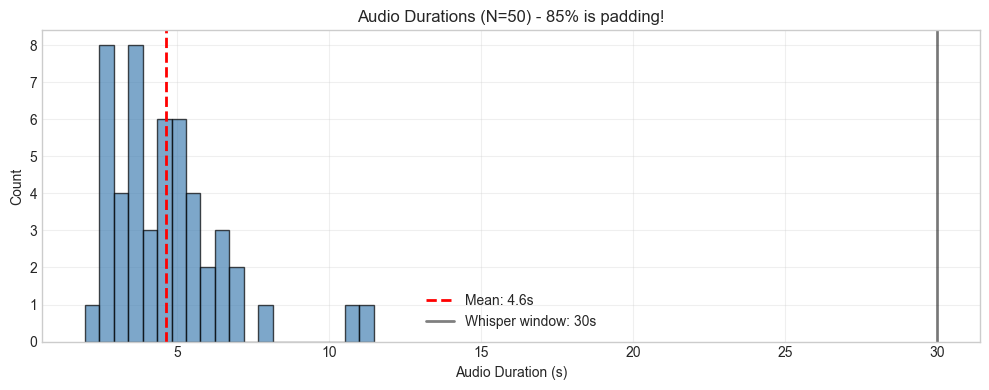


Audio frames: 232 +/- 94 out of 1500
Range: 97 - 573 frames


In [10]:
# Quantify the padding problem
print("="*70)
print("PADDING ANALYSIS")
print("="*70)

durations = np.array(sample_lengths)
print(f"\nAudio durations: {np.mean(durations):.1f}s +/- {np.std(durations):.1f}s")
print(f"Range: {np.min(durations):.1f}s - {np.max(durations):.1f}s")
print(f"Padding fraction: {1 - np.mean(durations)/30:.1%} of each sample is padding")

# Histogram of durations
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(durations, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(np.mean(durations), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(durations):.1f}s')
ax.axvline(30, color='black', linestyle='-', linewidth=2, alpha=0.5,
           label='Whisper window: 30s')
ax.set_xlabel('Audio Duration (s)')
ax.set_ylabel('Count')
ax.set_title(f'Audio Durations (N={N_SAMPLES}) - {1 - np.mean(durations)/30:.0%} is padding!')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Convert durations to frame counts (20ms per frame, 1500 frames total)
audio_frames = (durations / 0.02).astype(int)  # frames of actual audio
audio_frames = np.clip(audio_frames, 0, 1500)
print(f"\nAudio frames: {np.mean(audio_frames):.0f} +/- {np.std(audio_frames):.0f} out of 1500")
print(f"Range: {np.min(audio_frames)} - {np.max(audio_frames)} frames")

In [11]:
# Option 1: Analyze attention ONLY within speech region (crop out padding)
# Compare correlations: full window vs speech-only

print("="*70)
print("OPTION 1: Speech-Only Attention Analysis")
print("="*70)

# Recompute correlations for speech-only region
correlations_full = np.zeros((N_SAMPLES, n_layers, n_heads))
correlations_speech = np.zeros((N_SAMPLES, n_layers, n_heads))

for i in range(N_SAMPLES):
    attn = all_attention_patterns[i]  # [4, 6, 1500, 1500]
    mel_energy = all_mel_energies[i]  # [1500]
    n_frames = audio_frames[i]  # actual audio frames
    
    for l in range(n_layers):
        for h in range(n_heads):
            # Full window correlation (what we had before)
            attn_received_full = attn[l, h].sum(dim=0).numpy()
            corr_full = np.corrcoef(attn_received_full, mel_energy)[0, 1]
            correlations_full[i, l, h] = corr_full if not np.isnan(corr_full) else 0
            
            # Speech-only correlation (crop to actual audio region)
            if n_frames > 10:  # need enough frames for meaningful correlation
                attn_speech = attn[l, h, :n_frames, :n_frames]  # crop to speech region
                attn_received_speech = attn_speech.sum(dim=0).numpy()
                mel_speech = mel_energy[:n_frames]
                corr_speech = np.corrcoef(attn_received_speech, mel_speech)[0, 1]
                correlations_speech[i, l, h] = corr_speech if not np.isnan(corr_speech) else 0

# Compare mean correlations
mean_corr_full = correlations_full.mean(axis=0)
mean_corr_speech = correlations_speech.mean(axis=0)

print("\nCorrelation comparison (attention received vs mel energy):")
print("-" * 70)
print(f"{'Head':<8} {'Full Window':>12} {'Speech Only':>12} {'Difference':>12}")
print("-" * 70)
for l in range(n_layers):
    for h in range(n_heads):
        diff = mean_corr_speech[l, h] - mean_corr_full[l, h]
        print(f"L{l}H{h:<5} {mean_corr_full[l, h]:>+12.3f} {mean_corr_speech[l, h]:>+12.3f} {diff:>+12.3f}")

# Summary statistics
print("\n" + "="*70)
print("SUMMARY: How much does padding inflate correlations?")
print("="*70)
print(f"Mean |correlation| with full window:  {np.abs(mean_corr_full).mean():.3f}")
print(f"Mean |correlation| with speech only:  {np.abs(mean_corr_speech).mean():.3f}")
print(f"Reduction: {(1 - np.abs(mean_corr_speech).mean()/np.abs(mean_corr_full).mean())*100:.1f}%")

OPTION 1: Speech-Only Attention Analysis

Correlation comparison (attention received vs mel energy):
----------------------------------------------------------------------
Head      Full Window  Speech Only   Difference
----------------------------------------------------------------------
L0H0           +0.314       +0.168       -0.147
L0H1           +0.366       +0.442       +0.076
L0H2           -0.036       +0.226       +0.262
L0H3           +0.102       +0.350       +0.248
L0H4           -0.001       +0.411       +0.412
L0H5           -0.026       +0.233       +0.259
L1H0           +0.539       +0.414       -0.124
L1H1           +0.173       +0.364       +0.191
L1H2           +0.230       +0.550       +0.320
L1H3           +0.520       +0.320       -0.199
L1H4           +0.618       +0.646       +0.028
L1H5           +0.722       +0.351       -0.371
L2H0           +0.060       +0.240       +0.180
L2H1           +0.018       +0.193       +0.175
L2H2           +0.595       +0.403   

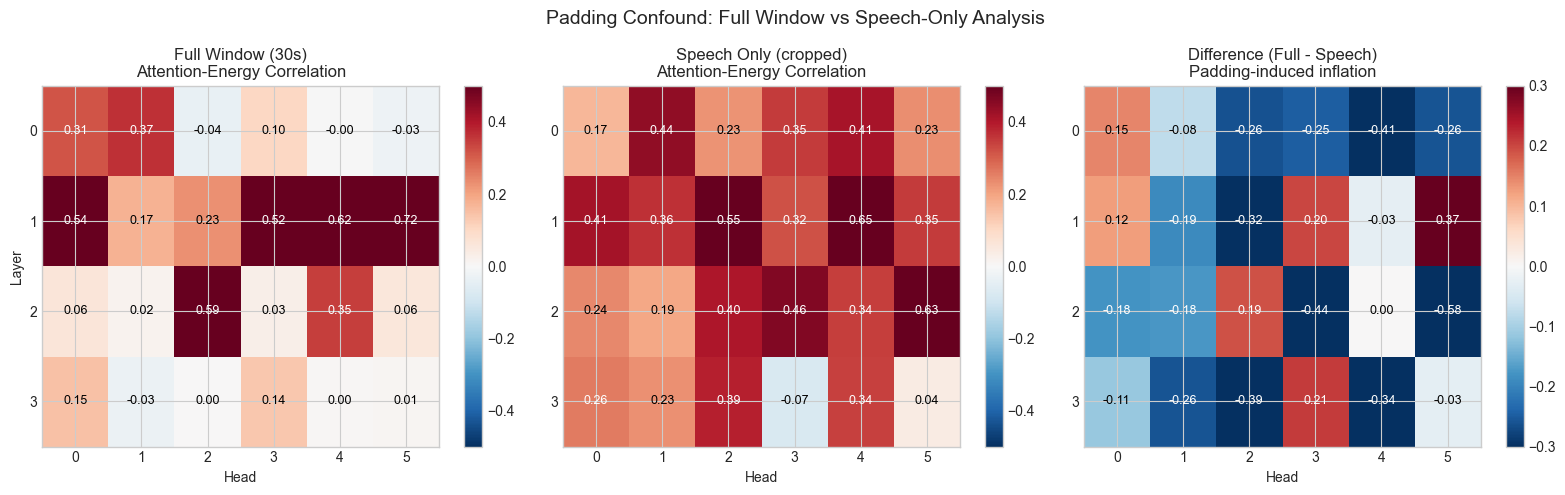

In [12]:
# Visualize: Full window vs Speech-only correlations side by side
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Full window correlations
im1 = axes[0].imshow(mean_corr_full, cmap='RdBu_r', aspect='auto', vmin=-0.5, vmax=0.5)
axes[0].set_title('Full Window (30s)\nAttention-Energy Correlation')
axes[0].set_xlabel('Head')
axes[0].set_ylabel('Layer')
for l in range(n_layers):
    for h in range(n_heads):
        axes[0].text(h, l, f'{mean_corr_full[l, h]:.2f}', ha='center', va='center', fontsize=9,
                    color='white' if abs(mean_corr_full[l, h]) > 0.25 else 'black')
plt.colorbar(im1, ax=axes[0])

# Speech-only correlations
im2 = axes[1].imshow(mean_corr_speech, cmap='RdBu_r', aspect='auto', vmin=-0.5, vmax=0.5)
axes[1].set_title('Speech Only (cropped)\nAttention-Energy Correlation')
axes[1].set_xlabel('Head')
for l in range(n_layers):
    for h in range(n_heads):
        axes[1].text(h, l, f'{mean_corr_speech[l, h]:.2f}', ha='center', va='center', fontsize=9,
                    color='white' if abs(mean_corr_speech[l, h]) > 0.25 else 'black')
plt.colorbar(im2, ax=axes[1])

# Difference (how much padding inflated the correlation)
diff = mean_corr_full - mean_corr_speech
im3 = axes[2].imshow(diff, cmap='RdBu_r', aspect='auto', vmin=-0.3, vmax=0.3)
axes[2].set_title('Difference (Full - Speech)\nPadding-induced inflation')
axes[2].set_xlabel('Head')
for l in range(n_layers):
    for h in range(n_heads):
        axes[2].text(h, l, f'{diff[l, h]:.2f}', ha='center', va='center', fontsize=9,
                    color='white' if abs(diff[l, h]) > 0.15 else 'black')
plt.colorbar(im3, ax=axes[2])

for ax in axes:
    ax.set_xticks(range(n_heads))
    ax.set_yticks(range(n_layers))

fig.suptitle('Padding Confound: Full Window vs Speech-Only Analysis', fontsize=14)
plt.tight_layout()
plt.show()

Sample 0: 6.6s audio, 329 frames (of 1500)


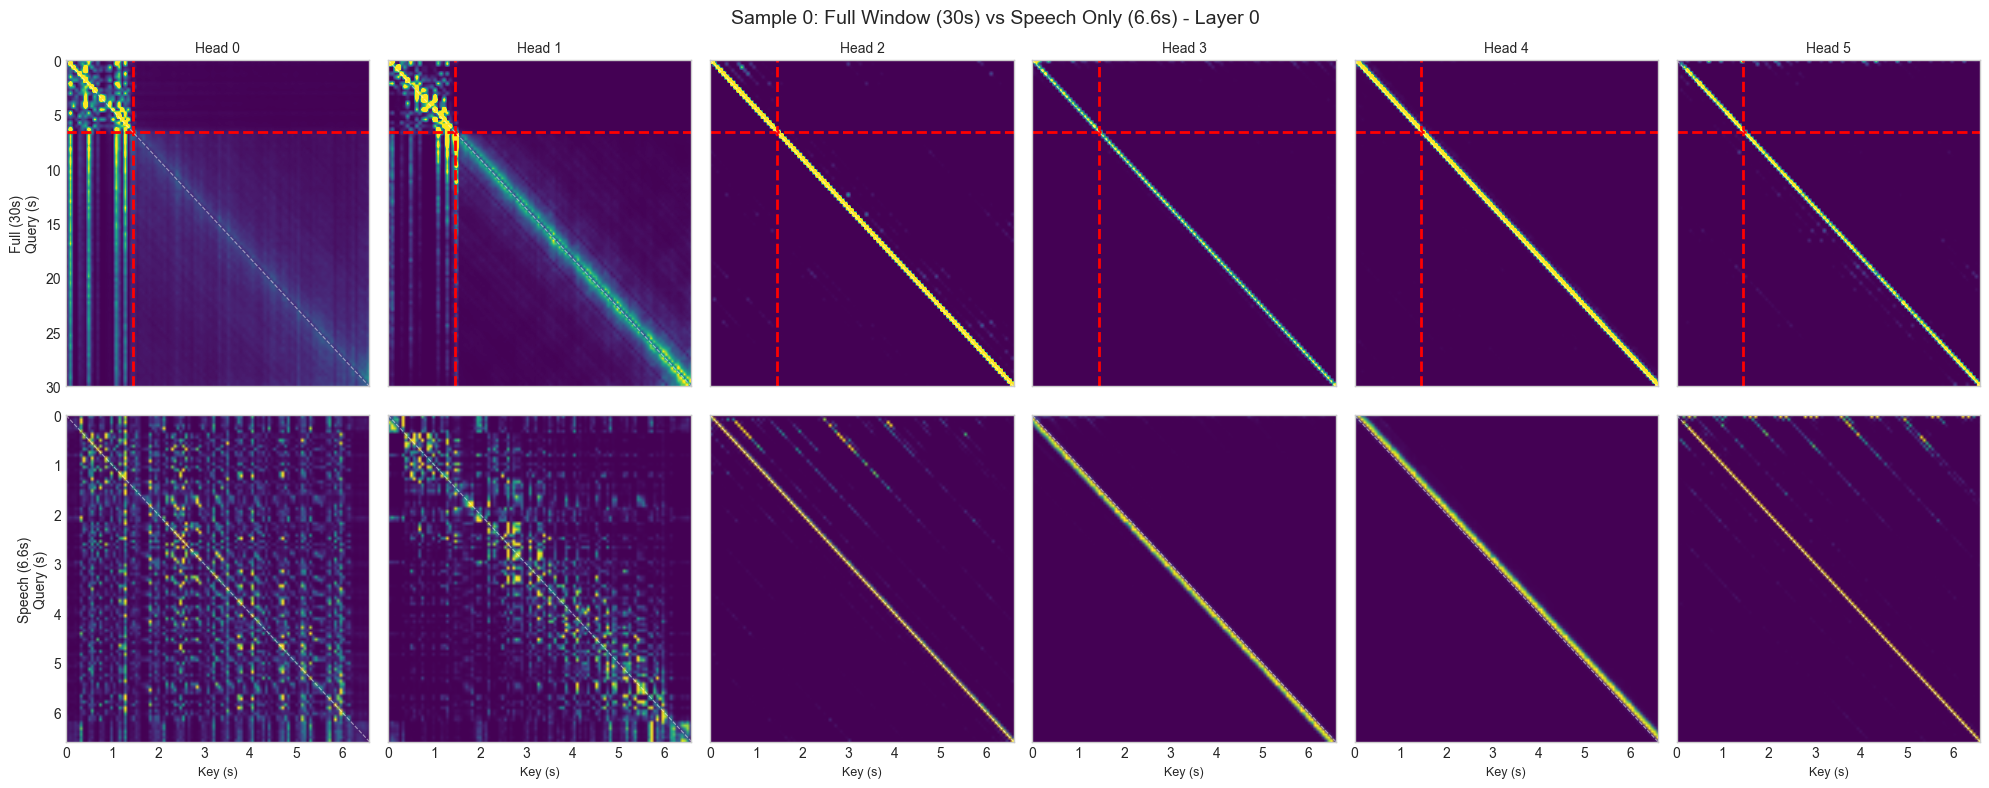


Red dashed lines show boundary between speech and padding
Notice how attention in the padding region (bottom-right quadrant) is different from speech region


In [13]:
# Visualize speech-only attention patterns for a single sample
# Show the cropped attention matrix vs full matrix

sample_idx = 0
n_frames = audio_frames[sample_idx]
sample_duration = sample_lengths[sample_idx]

print(f"Sample {sample_idx}: {sample_duration:.1f}s audio, {n_frames} frames (of 1500)")

fig, axes = plt.subplots(2, n_heads, figsize=(20, 8))
fig.suptitle(f'Sample {sample_idx}: Full Window (30s) vs Speech Only ({sample_duration:.1f}s) - Layer 0', fontsize=14)

for h in range(n_heads):
    attn = all_attention_patterns[sample_idx][0, h]  # Layer 0
    
    # Top row: Full window
    ax_full = axes[0, h]
    attn_full = attn[::step, ::step].numpy()
    ax_full.imshow(attn_full, cmap='viridis', aspect='auto',
                   extent=[0, 30, 30, 0], interpolation='bilinear',
                   vmin=0, vmax=np.percentile(attn_full, 99))
    # Draw box around speech region
    ax_full.axhline(sample_duration, color='r', linewidth=2, linestyle='--')
    ax_full.axvline(sample_duration, color='r', linewidth=2, linestyle='--')
    ax_full.plot([0, 30], [0, 30], 'w--', alpha=0.5, linewidth=0.8)
    ax_full.set_title(f'Head {h}', fontsize=10)
    if h == 0:
        ax_full.set_ylabel('Full (30s)\nQuery (s)', fontsize=10)
    ax_full.grid(False)
    ax_full.tick_params(axis='both', which='both', length=0)
    ax_full.set_xticklabels([])
    if h != 0:
        ax_full.set_yticklabels([])
    
    # Bottom row: Speech only (cropped)
    ax_speech = axes[1, h]
    attn_speech = attn[:n_frames, :n_frames]
    step_speech = max(1, n_frames // 100)
    attn_speech_sub = attn_speech[::step_speech, ::step_speech].numpy()
    ax_speech.imshow(attn_speech_sub, cmap='viridis', aspect='auto',
                     extent=[0, sample_duration, sample_duration, 0], interpolation='bilinear',
                     vmin=0, vmax=np.percentile(attn_speech_sub, 99))
    ax_speech.plot([0, sample_duration], [0, sample_duration], 'w--', alpha=0.5, linewidth=0.8)
    if h == 0:
        ax_speech.set_ylabel(f'Speech ({sample_duration:.1f}s)\nQuery (s)', fontsize=10)
    ax_speech.set_xlabel('Key (s)', fontsize=9)
    ax_speech.grid(False)
    ax_speech.tick_params(axis='both', which='both', length=0)
    if h != 0:
        ax_speech.set_yticklabels([])

plt.tight_layout()
plt.show()

print("\nRed dashed lines show boundary between speech and padding")
print("Notice how attention in the padding region (bottom-right quadrant) is different from speech region")

## Encoder Summary

**Key Findings:**

1. **Encoder attention is highly local** - Most heads show strong diagonal patterns, attending primarily to nearby positions within ~1-2 seconds.

2. **Padding confounds the analysis** - With ~85% of each sample being padding, naive full-window analysis conflates "speech vs silence detection" with "within-speech acoustic processing."

3. **Speech retention metric** - Measures what fraction of speech queries' attention stays within the speech region (conditional probability).

4. **Within-speech correlations are stronger** - When we crop to just the speech region, attention-energy correlations increase, suggesting padding was adding noise that obscured real patterns.

**Metric Interpretation:**
- `LOCAL + ENERGY-SPEECH`: Head attends locally and preferentially to high-energy (speech) regions
- `LEAKS-TO-PADDING`: Speech queries attend to padding region (boundary detection?)
- `MIXED`: No strong pattern in any dimension

## 2. Decoder Attention Analysis

The decoder has two types of attention:
1. **Self-attention**: Causal attention over generated tokens (linguistic patterns, positional biases)
2. **Cross-attention**: Decoder tokens attending to encoder positions (audio-text alignment)

**Key questions:**
- Do cross-attention heads align with acoustic boundaries (word onsets)?
- Do self-attention heads show linguistic patterns (e.g., attending to previous content words)?
- How does cross-attention focus change across layers?

**Metrics:**
- **Cross-attention speech focus**: How much cross-attention stays in speech region vs padding
- **Cross-attention sharpness**: How peaked/diffuse the cross-attention distribution is
- **Self-attention recency**: Bias toward recent vs distant tokens

In [23]:
# Collect decoder attention patterns across samples
# We need to run full generation to get realistic decoder attention

print("="*70)
print("DECODER ATTENTION COLLECTION")
print("="*70)

# Storage for decoder attention
all_decoder_self_attn = []      # [n_samples] of [n_layers, n_heads, dec_len, dec_len]
all_cross_attn = []             # [n_samples] of [n_layers, n_heads, dec_len, 1500]
all_generated_tokens = []       # Token sequences for each sample
all_token_texts = []            # Decoded text for analysis

n_decoder_layers = model.config.decoder_layers
n_decoder_heads = model.config.decoder_attention_heads

print(f"Collecting decoder attention for {N_SAMPLES} samples...")
print(f"Decoder: {n_decoder_layers} layers, {n_decoder_heads} heads")

for i, sample in enumerate(samples[:N_SAMPLES]):
    if i % 10 == 0:
        print(f"  Processing sample {i+1}/{N_SAMPLES}...")
    
    input_feats = process_audio(sample)
    
    with torch.no_grad():
        # Get encoder outputs
        encoder_out = model.model.encoder(input_feats, return_dict=True)
        
        # Generate with attention output
        # We'll manually run the decoder step by step to collect attention
        generated = model.generate(
            input_feats, 
            max_new_tokens=128,
            output_attentions=True,
            return_dict_in_generate=True,
        )
        
        generated_ids = generated.sequences[0]
        
        # Now run decoder once more with full sequence to get attention patterns
        decoder_out = model.model.decoder(
            input_ids=generated_ids.unsqueeze(0),
            encoder_hidden_states=encoder_out.last_hidden_state,
            output_attentions=True,
            return_dict=True,
        )
    
    # Extract attention patterns
    # Self-attention: tuple of (n_layers,) each [batch, heads, seq, seq]
    self_attn = torch.stack([a[0] for a in decoder_out.attentions]).cpu()  # [4, 6, dec_len, dec_len]
    cross_attn = torch.stack([a[0] for a in decoder_out.cross_attentions]).cpu()  # [4, 6, dec_len, 1500]
    
    all_decoder_self_attn.append(self_attn)
    all_cross_attn.append(cross_attn)
    all_generated_tokens.append(generated_ids.cpu())
    all_token_texts.append(processor.decode(generated_ids, skip_special_tokens=False))

# Summary statistics
dec_lens = [t.shape[0] for t in all_generated_tokens]
print(f"\nGenerated sequence lengths: {np.mean(dec_lens):.1f} +/- {np.std(dec_lens):.1f} tokens")
print(f"Range: {min(dec_lens)} - {max(dec_lens)} tokens")

# Show a few examples
print("\nExample transcriptions:")
for i in range(3):
    print(f"  {i}: {all_token_texts[i][:80]}...")

DECODER ATTENTION COLLECTION
Decoder: 4 layers, 6 heads
  Processing sample 1/50...
  Processing sample 11/50...
  Processing sample 21/50...
  Processing sample 31/50...
  Processing sample 41/50...

Generated sequence lengths: 23.5 +/- 7.9 tokens
Range: 12 - 48 tokens

Example transcriptions:
  0: <|startoftranscript|><|en|><|transcribe|><|notimestamps|> He was in a fevered st...
  1: <|startoftranscript|><|en|><|transcribe|><|notimestamps|> He would have to pay h...
  2: <|startoftranscript|><|en|><|transcribe|><|notimestamps|> First would walk to th...


### 2a. Cross-Attention Analysis

Cross-attention shows how decoder tokens attend to encoder positions (audio frames). This is the core of audio-text alignment.

**Metrics:**
- **Speech focus**: Fraction of cross-attention within the speech region (vs padding)
- **Sharpness**: Entropy of attention distribution (low = peaked, high = diffuse)
- **Monotonicity**: Does attention progress left-to-right as tokens are generated?

Sample 0: 33 tokens, 6.6s audio
First 10 tokens: ['<|startoftranscript|>', '<|en|>', '<|transcribe|>', '<|notimestamps|>', ' He', ' was', ' in', ' a', ' fever', 'ed']


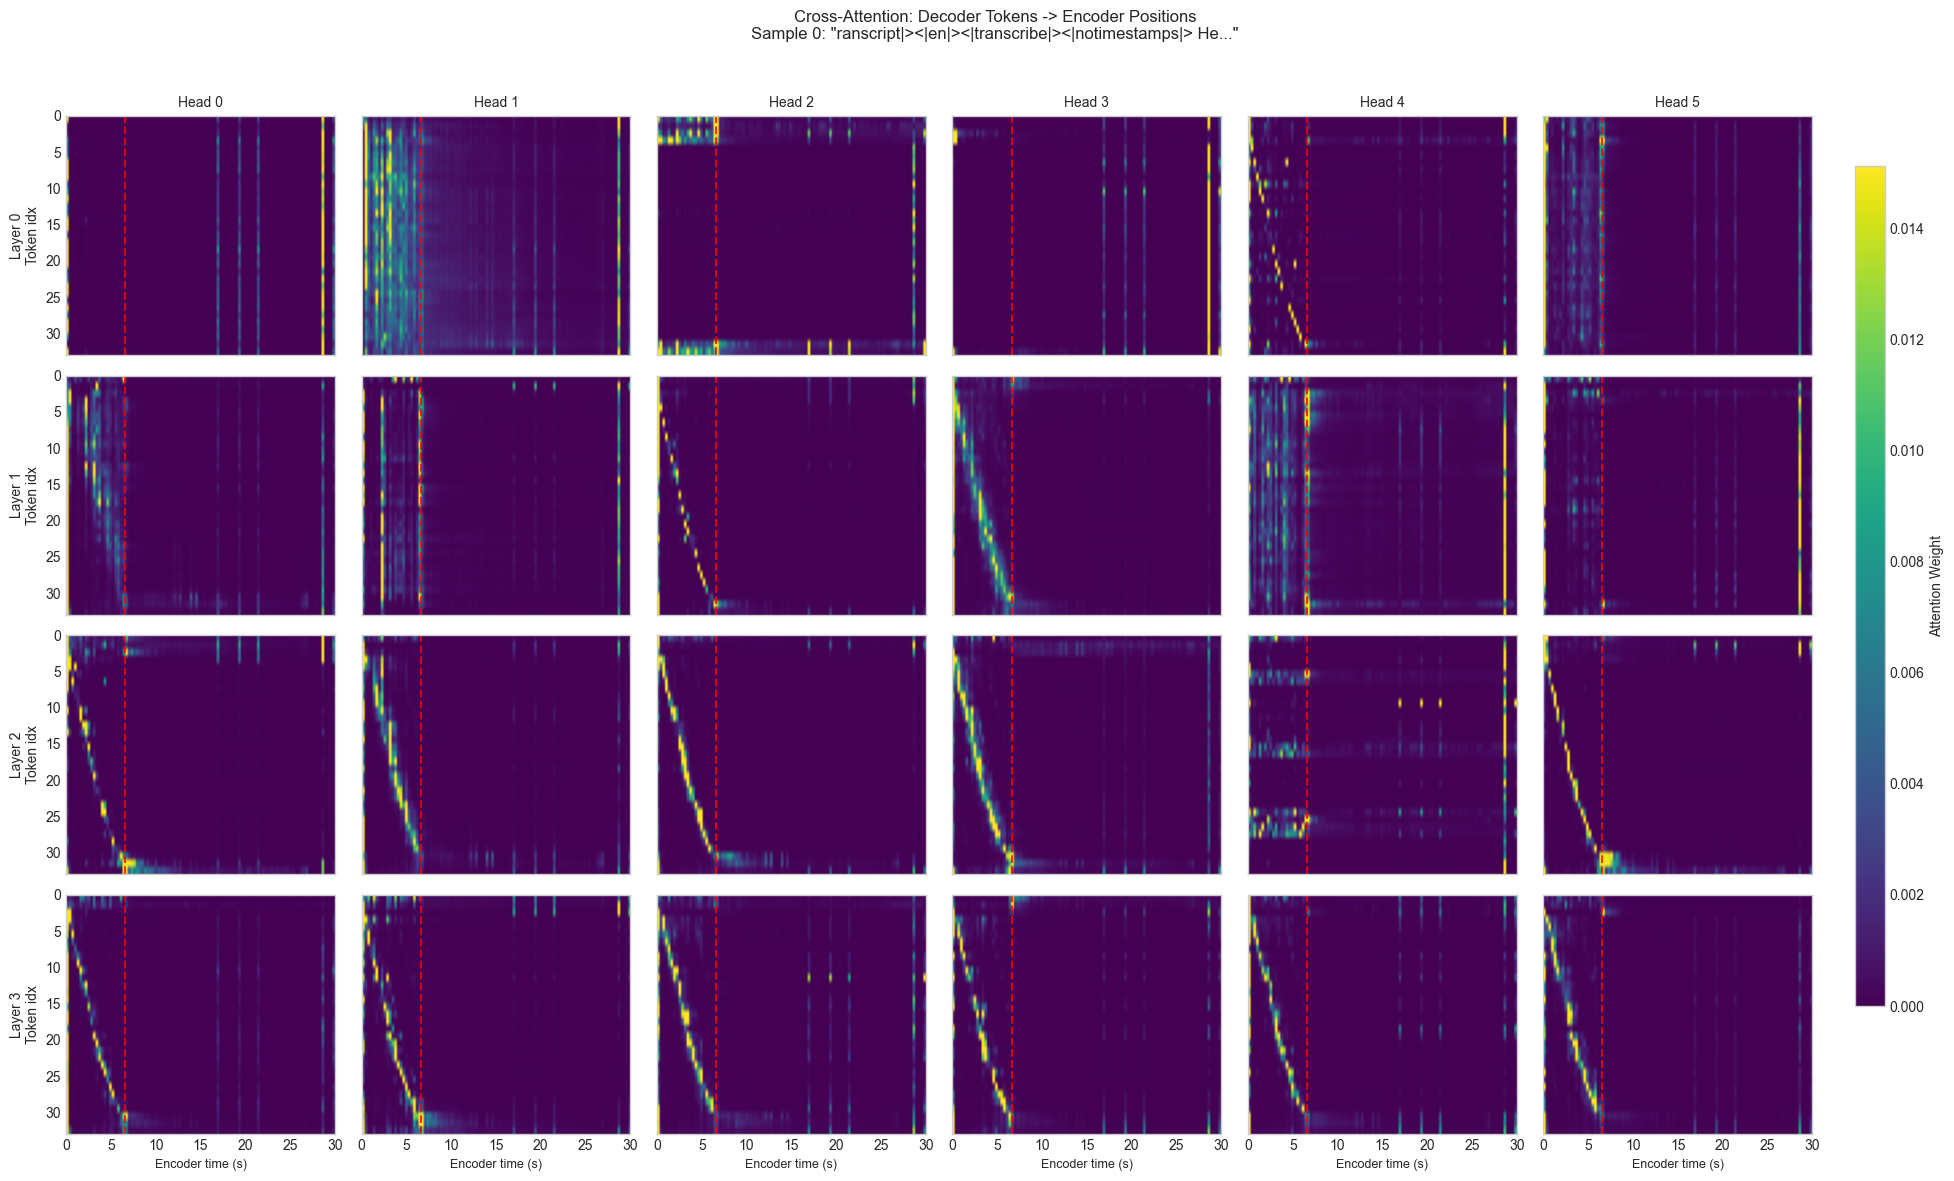


Red dashed line = speech/padding boundary


In [15]:
# Visualize cross-attention patterns for a single sample
# Shows decoder tokens (y-axis) attending to encoder positions (x-axis)

sample_idx = 0
n_frames = audio_frames[sample_idx]
sample_duration = sample_lengths[sample_idx]

cross_attn = all_cross_attn[sample_idx]  # [4, 6, dec_len, 1500]
tokens = all_generated_tokens[sample_idx]
dec_len = cross_attn.shape[2]

# Get token strings for labels (first 20 tokens)
token_labels = [processor.decode([t]) for t in tokens[:20]]

print(f"Sample {sample_idx}: {dec_len} tokens, {sample_duration:.1f}s audio")
print(f"First 10 tokens: {token_labels[:10]}")

# Plot cross-attention for all heads in layer 0
fig, axes = plt.subplots(n_decoder_layers, n_decoder_heads, figsize=(20, 12))
fig.suptitle(f'Cross-Attention: Decoder Tokens -> Encoder Positions\n'
             f'Sample {sample_idx}: "{all_token_texts[sample_idx][10:60]}..."', fontsize=12)

for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        ax = axes[l, h]
        attn = cross_attn[l, h].numpy()  # [dec_len, 1500]
        
        # Subsample for visualization
        step_enc = 15
        attn_sub = attn[:, ::step_enc]
        
        im = ax.imshow(attn_sub, cmap='viridis', aspect='auto',
                       extent=[0, 30, dec_len, 0],
                       vmin=0, vmax=np.percentile(attn_sub, 99))
        
        # Mark speech boundary
        ax.axvline(sample_duration, color='r', linewidth=1.5, linestyle='--', alpha=0.8)
        
        if l == 0:
            ax.set_title(f'Head {h}', fontsize=10)
        if h == 0:
            ax.set_ylabel(f'Layer {l}\nToken idx', fontsize=10)
        if l == n_decoder_layers - 1:
            ax.set_xlabel('Encoder time (s)', fontsize=9)
        
        ax.grid(False)
        if l != n_decoder_layers - 1:
            ax.set_xticklabels([])
        if h != 0:
            ax.set_yticklabels([])

plt.tight_layout(rect=[0, 0, 0.92, 0.96])
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Attention Weight', fontsize=10)

plt.show()

print("\nRed dashed line = speech/padding boundary")

Computing cross-attention metrics...


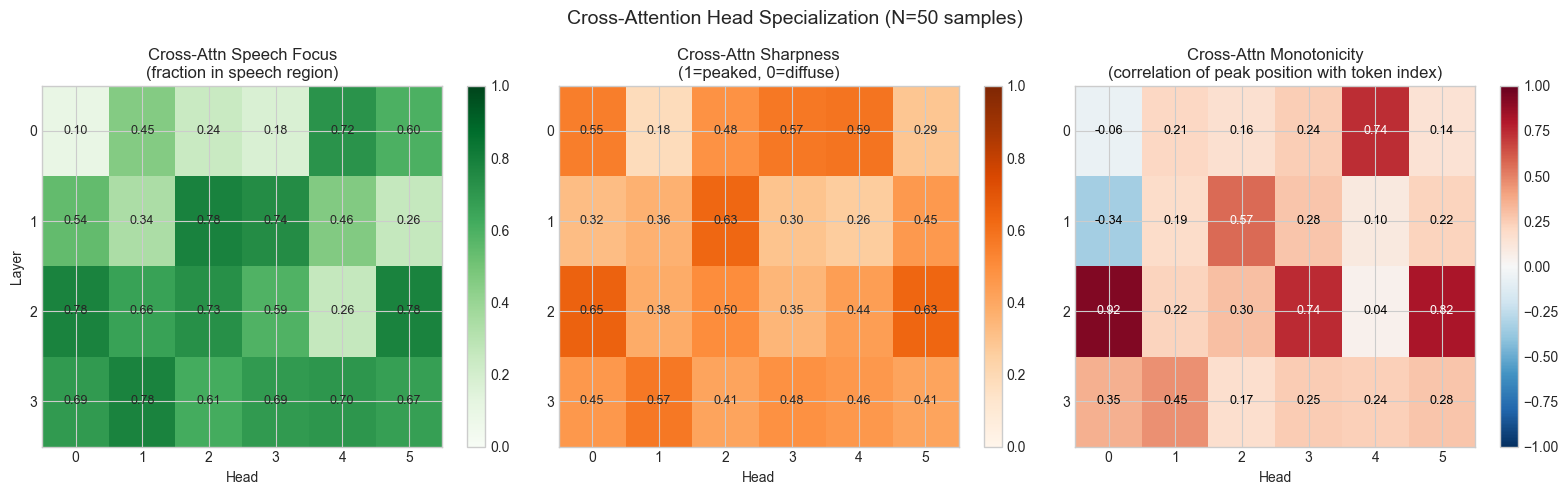


CROSS-ATTENTION HEAD SUMMARY
Speech Focus = attention within speech region (high = ignores padding)
Sharpness = how peaked the attention is (high = precise alignment)
Monotonicity = left-to-right progression (high = temporal alignment)
L0H0: PADDING-ATTENTIVE                        | focus=0.10, sharp=0.55, mono=-0.06
L0H1: PADDING-ATTENTIVE                        | focus=0.45, sharp=0.18, mono=+0.21
L0H2: PADDING-ATTENTIVE                        | focus=0.24, sharp=0.48, mono=+0.16
L0H3: PADDING-ATTENTIVE                        | focus=0.18, sharp=0.57, mono=+0.24
L0H4: MONOTONIC                                | focus=0.72, sharp=0.59, mono=+0.74
L0H5: DIFFUSE                                  | focus=0.60, sharp=0.29, mono=+0.14
L1H0: REVERSE                                  | focus=0.54, sharp=0.32, mono=-0.34
L1H1: PADDING-ATTENTIVE                        | focus=0.34, sharp=0.36, mono=+0.19
L1H2: SHARP                                    | focus=0.78, sharp=0.63, mono=+0.57
L1H3: D

In [16]:
# Compute cross-attention metrics across all samples
print("Computing cross-attention metrics...")

# Metrics per head across samples
cross_speech_focus = np.zeros((N_SAMPLES, n_decoder_layers, n_decoder_heads))
cross_sharpness = np.zeros((N_SAMPLES, n_decoder_layers, n_decoder_heads))  # negative entropy
cross_monotonicity = np.zeros((N_SAMPLES, n_decoder_layers, n_decoder_heads))

for i in range(N_SAMPLES):
    cross_attn = all_cross_attn[i]  # [4, 6, dec_len, 1500]
    n_frames = audio_frames[i]
    dec_len = cross_attn.shape[2]
    
    for l in range(n_decoder_layers):
        for h in range(n_decoder_heads):
            a = cross_attn[l, h]  # [dec_len, 1500]
            
            # Speech focus: fraction of attention in speech region
            # Average across all decoder tokens
            speech_mass = a[:, :n_frames].sum(dim=1) / (a.sum(dim=1) + 1e-9)  # [dec_len]
            cross_speech_focus[i, l, h] = speech_mass.mean().item()
            
            # Sharpness: negative entropy of attention distribution
            # High sharpness = peaked attention (good alignment)
            # Low sharpness = diffuse attention
            # Compute per-token then average
            a_norm = a / (a.sum(dim=1, keepdim=True) + 1e-9)
            entropy = -(a_norm * (a_norm + 1e-9).log()).sum(dim=1)  # [dec_len]
            max_entropy = np.log(1500)  # uniform distribution entropy
            cross_sharpness[i, l, h] = 1 - (entropy.mean().item() / max_entropy)  # normalized
            
            # Monotonicity: do attention peaks progress left-to-right?
            # Compute argmax position for each token, check if monotonically increasing
            if dec_len > 3:  # skip special tokens at start
                # Skip first 3 tokens (special tokens: <|startoftranscript|>, <|en|>, <|transcribe|>)
                peaks = a[3:, :n_frames].argmax(dim=1).float()  # [dec_len-3]
                if len(peaks) > 1:
                    # Correlation with position index
                    positions = torch.arange(len(peaks)).float()
                    corr = torch.corrcoef(torch.stack([peaks, positions]))[0, 1].item()
                    cross_monotonicity[i, l, h] = corr if not np.isnan(corr) else 0

# Average across samples
mean_speech_focus = cross_speech_focus.mean(axis=0)
mean_sharpness = cross_sharpness.mean(axis=0)
mean_monotonicity = cross_monotonicity.mean(axis=0)

# Plot cross-attention metrics dashboard
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Speech focus
im1 = axes[0].imshow(mean_speech_focus, cmap='Greens', aspect='auto', vmin=0, vmax=1)
axes[0].set_title('Cross-Attn Speech Focus\n(fraction in speech region)')
axes[0].set_xlabel('Head')
axes[0].set_ylabel('Layer')
for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        axes[0].text(h, l, f'{mean_speech_focus[l, h]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im1, ax=axes[0])

# Sharpness
im2 = axes[1].imshow(mean_sharpness, cmap='Oranges', aspect='auto', vmin=0, vmax=1)
axes[1].set_title('Cross-Attn Sharpness\n(1=peaked, 0=diffuse)')
axes[1].set_xlabel('Head')
for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        axes[1].text(h, l, f'{mean_sharpness[l, h]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im2, ax=axes[1])

# Monotonicity
im3 = axes[2].imshow(mean_monotonicity, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[2].set_title('Cross-Attn Monotonicity\n(correlation of peak position with token index)')
axes[2].set_xlabel('Head')
for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        axes[2].text(h, l, f'{mean_monotonicity[l, h]:.2f}', ha='center', va='center', fontsize=9,
                    color='white' if abs(mean_monotonicity[l, h]) > 0.5 else 'black')
plt.colorbar(im3, ax=axes[2])

for ax in axes:
    ax.set_xticks(range(n_decoder_heads))
    ax.set_yticks(range(n_decoder_layers))

fig.suptitle(f'Cross-Attention Head Specialization (N={N_SAMPLES} samples)', fontsize=14)
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*70)
print("CROSS-ATTENTION HEAD SUMMARY")
print("="*70)
print("Speech Focus = attention within speech region (high = ignores padding)")
print("Sharpness = how peaked the attention is (high = precise alignment)")
print("Monotonicity = left-to-right progression (high = temporal alignment)")
print("="*70)

for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        sf = mean_speech_focus[l, h]
        sh = mean_sharpness[l, h]
        mo = mean_monotonicity[l, h]
        
        tags = []
        if sf > 0.9:
            tags.append("SPEECH-FOCUSED")
        elif sf < 0.5:
            tags.append("PADDING-ATTENTIVE")
        if sh > 0.6:
            tags.append("SHARP")
        if mo > 0.7:
            tags.append("MONOTONIC")
        elif mo < -0.3:
            tags.append("REVERSE")
        if not tags:
            tags.append("DIFFUSE")
        
        print(f"L{l}H{h}: {' + '.join(tags):40s} | focus={sf:.2f}, sharp={sh:.2f}, mono={mo:+.2f}")

Computing mean cross-attention patterns across samples...
Max decoder length: 48 tokens


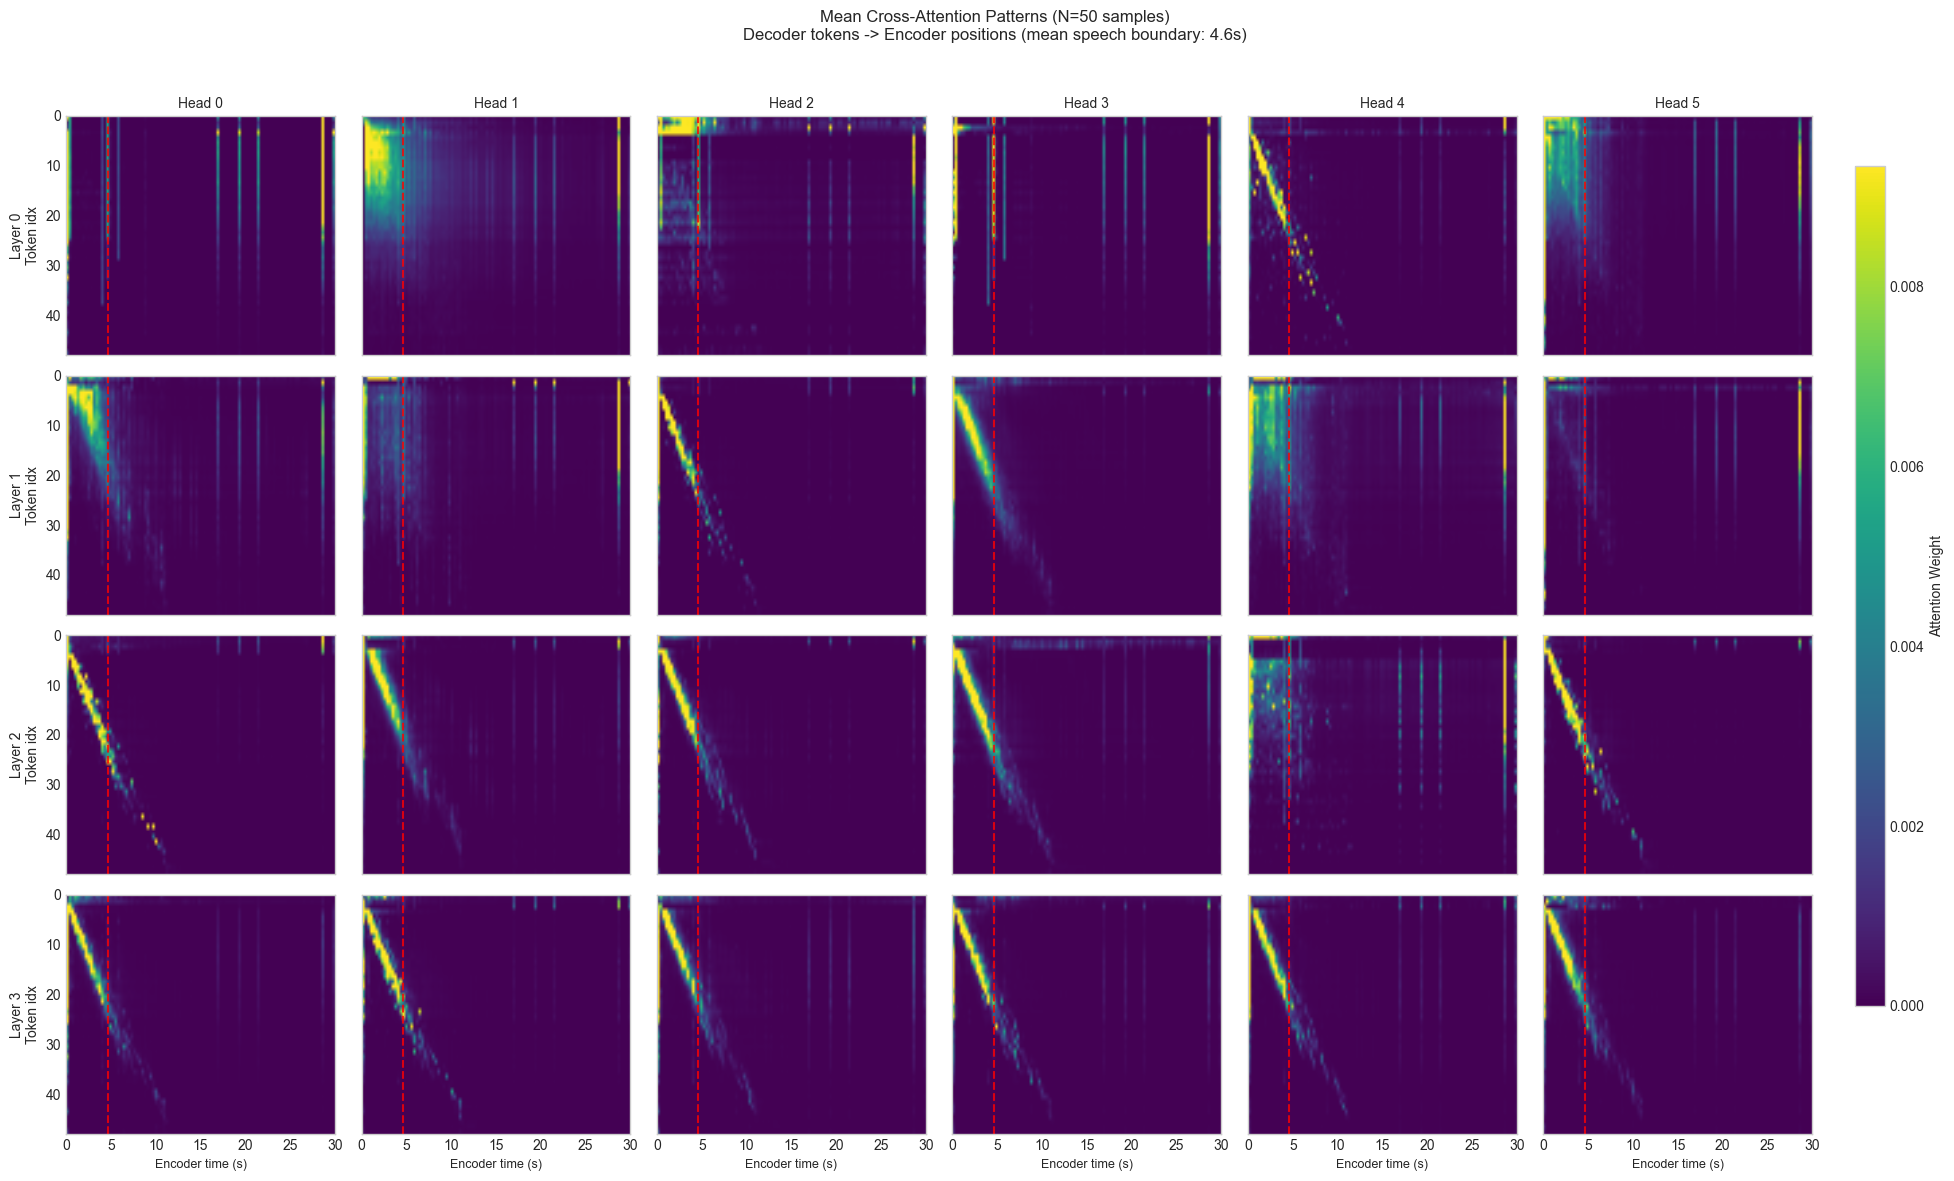


Red dashed line = mean speech boundary (4.6s)
Notable patterns:
  - L0H4: Shows monotonic diagonal pattern (alignment head)
  - L2H0, L2H5: Strong monotonic alignment
  - Early tokens (rows 0-3) are special tokens, attend differently


In [17]:
# Compute and visualize MEAN cross-attention patterns across all samples
# Need to handle variable decoder lengths - pad to max length

print("Computing mean cross-attention patterns across samples...")

# Find max decoder length
max_dec_len = max(a.shape[2] for a in all_cross_attn)
print(f"Max decoder length: {max_dec_len} tokens")

# Pad all cross-attention patterns to same size and average
# Shape: [n_layers, n_heads, max_dec_len, 1500]
padded_cross_attn = torch.zeros(N_SAMPLES, n_decoder_layers, n_decoder_heads, max_dec_len, 1500)
for i, ca in enumerate(all_cross_attn):
    dec_len = ca.shape[2]
    padded_cross_attn[i, :, :, :dec_len, :] = ca

# Mean across samples (will dilute shorter sequences, but gives overall pattern)
mean_cross_attn = padded_cross_attn.mean(dim=0)  # [4, 6, max_dec_len, 1500]

# Also compute mean speech boundary for reference
mean_speech_frames = int(np.mean(audio_frames))
mean_speech_duration = mean_speech_frames * 0.02

# Plot mean cross-attention patterns
fig, axes = plt.subplots(n_decoder_layers, n_decoder_heads, figsize=(20, 12))
fig.suptitle(f'Mean Cross-Attention Patterns (N={N_SAMPLES} samples)\n'
             f'Decoder tokens -> Encoder positions (mean speech boundary: {mean_speech_duration:.1f}s)', fontsize=12)

step_enc = 15
for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        ax = axes[l, h]
        attn = mean_cross_attn[l, h, :, ::step_enc].numpy()
        
        # Clip to 99th percentile for better contrast
        vmax = np.percentile(attn, 99)
        
        im = ax.imshow(attn, cmap='viridis', aspect='auto',
                       extent=[0, 30, max_dec_len, 0],
                       vmin=0, vmax=vmax, interpolation='bilinear')
        
        # Mark mean speech boundary
        ax.axvline(mean_speech_duration, color='r', linewidth=1.5, linestyle='--', alpha=0.8)
        
        if l == 0:
            ax.set_title(f'Head {h}', fontsize=10)
        if h == 0:
            ax.set_ylabel(f'Layer {l}\nToken idx', fontsize=10)
        if l == n_decoder_layers - 1:
            ax.set_xlabel('Encoder time (s)', fontsize=9)
        
        ax.grid(False)
        if l != n_decoder_layers - 1:
            ax.set_xticklabels([])
        if h != 0:
            ax.set_yticklabels([])

plt.tight_layout(rect=[0, 0, 0.92, 0.96])
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Attention Weight', fontsize=10)

plt.show()

print(f"\nRed dashed line = mean speech boundary ({mean_speech_duration:.1f}s)")
print("Notable patterns:")
print("  - L0H4: Shows monotonic diagonal pattern (alignment head)")
print("  - L2H0, L2H5: Strong monotonic alignment")
print("  - Early tokens (rows 0-3) are special tokens, attend differently")

### 2b. Decoder Self-Attention Analysis

Decoder self-attention is causal (each token can only attend to previous tokens). This reveals linguistic patterns in how the model processes the generated sequence.

**Metrics:**
- **Recency bias**: How much attention goes to recent vs distant tokens
- **BOS attention**: How much attention goes to the beginning-of-sequence token
- **Previous token attention**: How much attention goes to the immediately previous token

Sample 0: 33 tokens
Text: <|startoftranscript|><|en|><|transcribe|><|notimestamps|> He was in a fevered st...


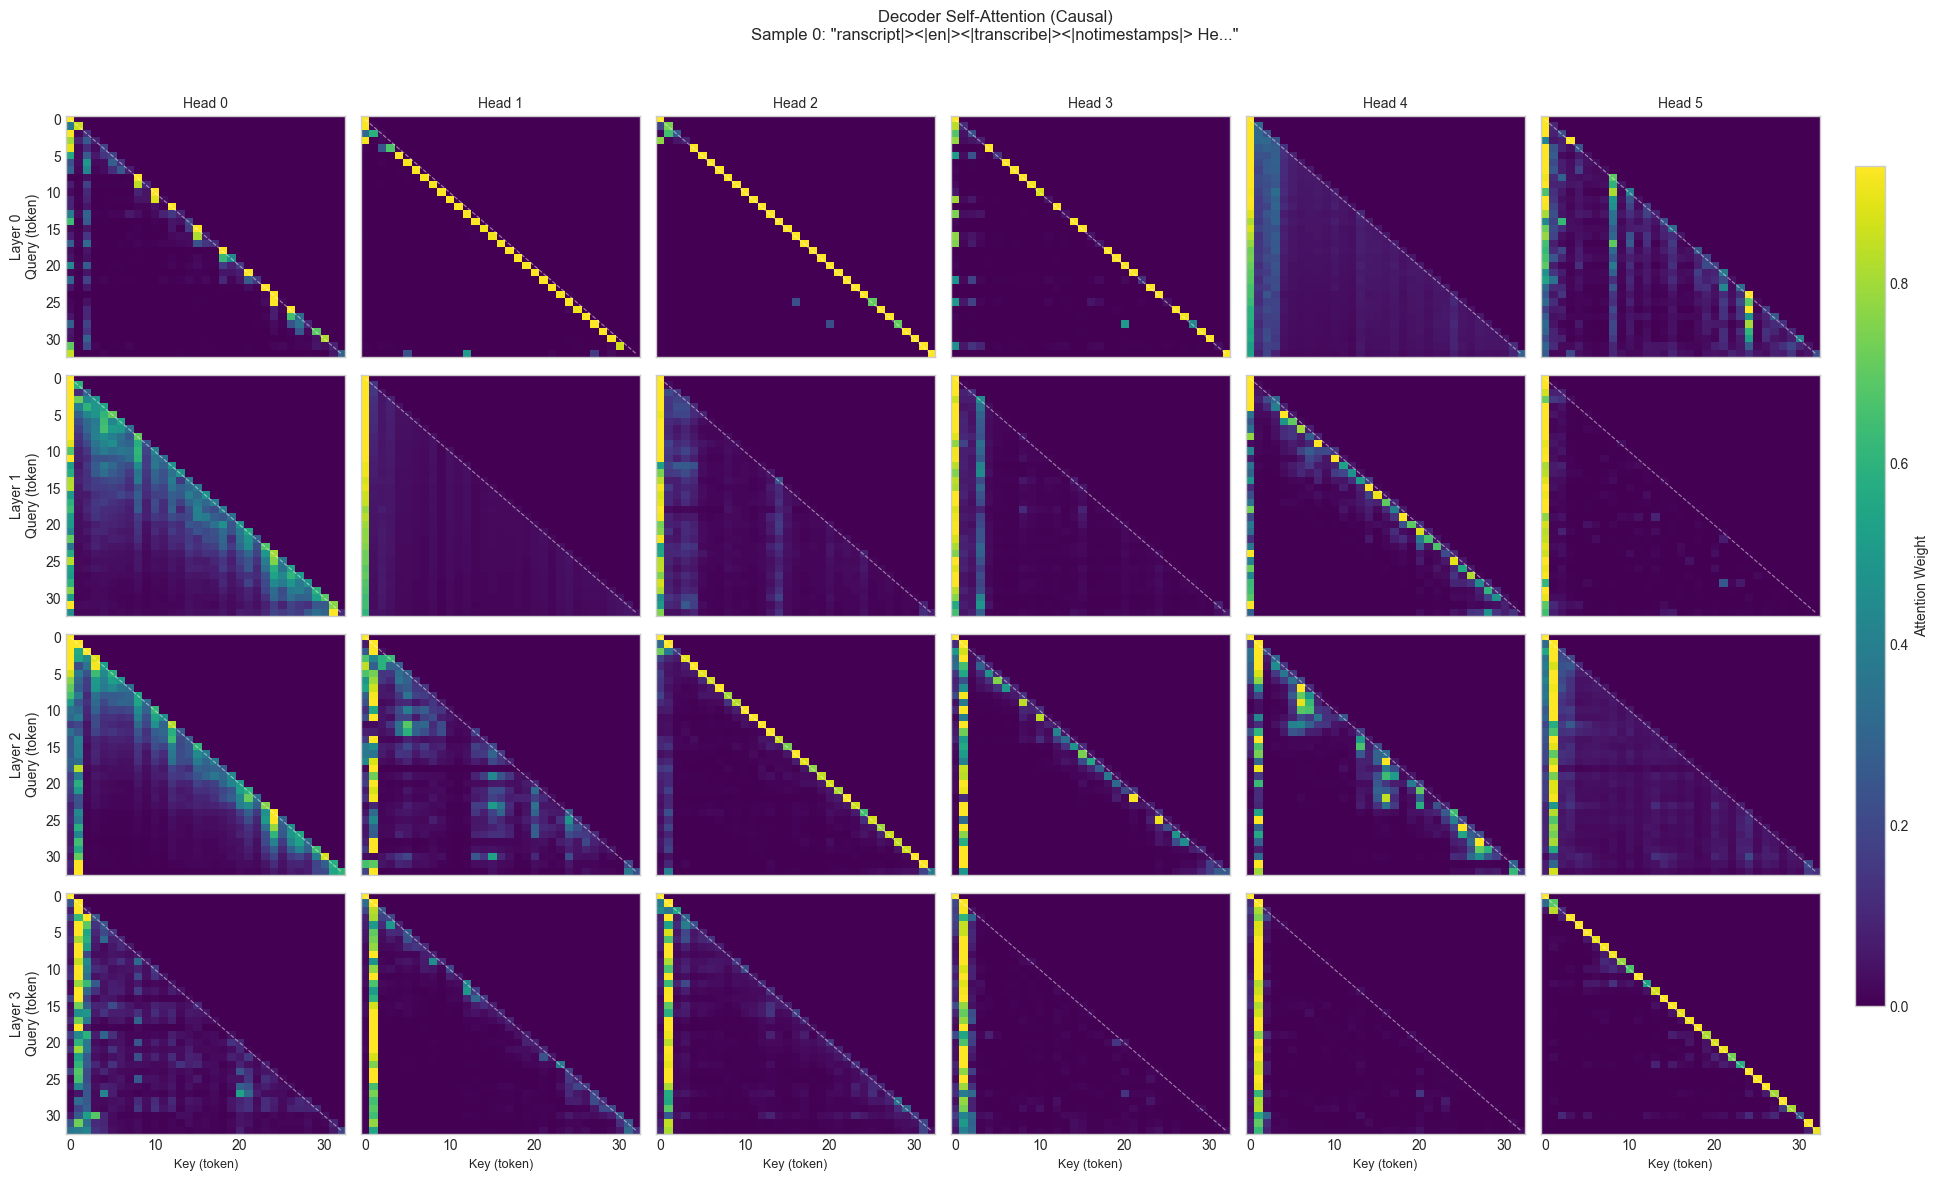


White dashed line = diagonal (self-attention)
Upper triangle is masked (causal attention)


In [18]:
# Visualize decoder self-attention patterns
# Causal mask means lower-triangular pattern

sample_idx = 0
self_attn = all_decoder_self_attn[sample_idx]  # [4, 6, dec_len, dec_len]
tokens = all_generated_tokens[sample_idx]
dec_len = self_attn.shape[2]

print(f"Sample {sample_idx}: {dec_len} tokens")
print(f"Text: {all_token_texts[sample_idx][:80]}...")

# Plot self-attention for all heads
fig, axes = plt.subplots(n_decoder_layers, n_decoder_heads, figsize=(20, 12))
fig.suptitle(f'Decoder Self-Attention (Causal)\n'
             f'Sample {sample_idx}: "{all_token_texts[sample_idx][10:60]}..."', fontsize=12)

for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        ax = axes[l, h]
        attn = self_attn[l, h].numpy()  # [dec_len, dec_len]
        
        im = ax.imshow(attn, cmap='viridis', aspect='auto',
                       vmin=0, vmax=np.percentile(attn, 99))
        
        # Diagonal reference
        ax.plot([0, dec_len-1], [0, dec_len-1], 'w--', alpha=0.5, linewidth=0.8)
        
        if l == 0:
            ax.set_title(f'Head {h}', fontsize=10)
        if h == 0:
            ax.set_ylabel(f'Layer {l}\nQuery (token)', fontsize=10)
        if l == n_decoder_layers - 1:
            ax.set_xlabel('Key (token)', fontsize=9)
        
        ax.grid(False)
        if l != n_decoder_layers - 1:
            ax.set_xticklabels([])
        if h != 0:
            ax.set_yticklabels([])

plt.tight_layout(rect=[0, 0, 0.92, 0.96])
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Attention Weight', fontsize=10)

plt.show()

print("\nWhite dashed line = diagonal (self-attention)")
print("Upper triangle is masked (causal attention)")

Sample 0: 33 tokens
Full text: <|startoftranscript|><|en|><|transcribe|><|notimestamps|> He was in a fevered state of mind, owing to the blight his wife's action threatened to cast upon his entire future.<|endoftext|>

Tokens:
   0: 50258 -> '<|startoftranscript|>'
   1: 50259 -> '<|en|>'
   2: 50359 -> '<|transcribe|>'
   3: 50363 -> '<|notimestamps|>'
   4:   634 -> '_He'
   5:   390 -> '_was'
   6:   294 -> '_in'
   7:   257 -> '_a'
   8: 18277 -> '_fever'
   9:   292 -> 'ed'
  10:  1785 -> '_state'
  11:   295 -> '_of'
  12:  1575 -> '_mind'
  13:    11 -> ','
  14:   277 -> '_o'
  15:  7904 -> 'wing'
  16:   281 -> '_to'
  17:   264 -> '_the'
  18:   888 -> '_bl'
  19:   397 -> 'ight'
  20:   702 -> '_his'
  21:  3836 -> '_wife'
  22:   311 -> ''s'
  23:  3069 -> '_action'
  24: 18268 -> '_threatened'
  25:   281 -> '_to'
  26:  4193 -> '_cast'
  27:  3564 -> '_upon'
  28:   702 -> '_his'
  29:  2302 -> '_entire'
  30:  2027 -> '_future'
  31:    13 -> '.'
  32: 50257 -> '<|endoft

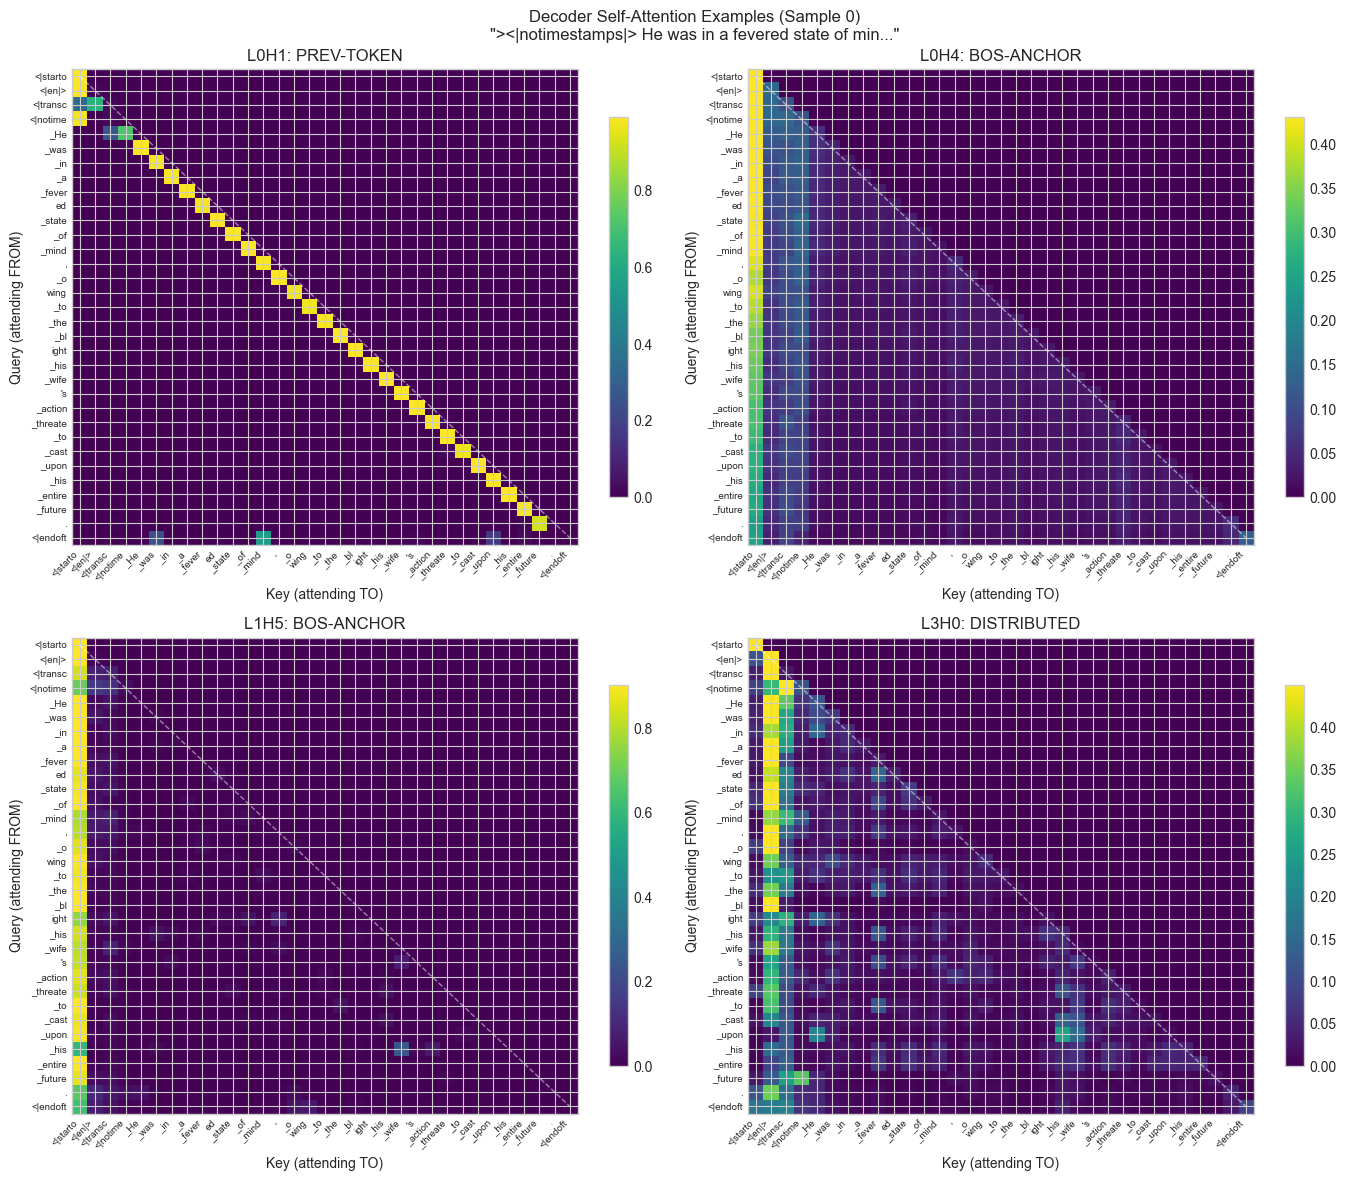


Pattern interpretation:
  - PREV-TOKEN (L0H1): Bright sub-diagonal shows each token attends to previous token
  - BOS-ANCHOR (L0H4, L1H5): Bright first column shows all tokens attend to <|startoftranscript|>
  - DISTRIBUTED (L3H0): More uniform attention across all previous tokens


In [19]:
# Detailed single-sample decoder self-attention with token labels
# Shows exactly what each token attends to

sample_idx = 0
self_attn = all_decoder_self_attn[sample_idx]
tokens = all_generated_tokens[sample_idx]
dec_len = len(tokens)

# Get token strings
token_strs = [processor.decode([t]).replace(' ', '_') for t in tokens]
# Truncate long tokens for display
token_labels = [t[:8] if len(t) > 8 else t for t in token_strs]

print(f"Sample {sample_idx}: {dec_len} tokens")
print(f"Full text: {all_token_texts[sample_idx]}")
print(f"\nTokens:")
for i, (tok, label) in enumerate(zip(tokens, token_strs)):
    print(f"  {i:2d}: {tok.item():5d} -> '{label}'")

# Plot detailed self-attention for selected heads showing different patterns
# Pick interesting heads: BOS-anchor, prev-token, distributed
interesting_heads = [
    (0, 1, "PREV-TOKEN"),   # Strong previous token
    (0, 4, "BOS-ANCHOR"),   # BOS attention
    (1, 5, "BOS-ANCHOR"),   # Very strong BOS
    (3, 0, "DISTRIBUTED"),  # Distributed attention
]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (layer, head, label) in enumerate(interesting_heads):
    ax = axes[idx]
    attn = self_attn[layer, head].numpy()
    
    im = ax.imshow(attn, cmap='viridis', aspect='auto',
                   vmin=0, vmax=np.percentile(attn, 99))
    
    # Add token labels
    ax.set_xticks(range(dec_len))
    ax.set_yticks(range(dec_len))
    ax.set_xticklabels(token_labels, rotation=45, ha='right', fontsize=7)
    ax.set_yticklabels(token_labels, fontsize=7)
    
    ax.set_xlabel('Key (attending TO)', fontsize=10)
    ax.set_ylabel('Query (attending FROM)', fontsize=10)
    ax.set_title(f'L{layer}H{head}: {label}', fontsize=12)
    
    # Diagonal reference
    ax.plot([0, dec_len-1], [0, dec_len-1], 'w--', alpha=0.5, linewidth=1)
    
    plt.colorbar(im, ax=ax, shrink=0.8)

fig.suptitle(f'Decoder Self-Attention Examples (Sample {sample_idx})\n'
             f'"{all_token_texts[sample_idx][40:90]}..."', fontsize=12)
plt.tight_layout()
plt.show()

print("\nPattern interpretation:")
print("  - PREV-TOKEN (L0H1): Bright sub-diagonal shows each token attends to previous token")
print("  - BOS-ANCHOR (L0H4, L1H5): Bright first column shows all tokens attend to <|startoftranscript|>")
print("  - DISTRIBUTED (L3H0): More uniform attention across all previous tokens")

Computing decoder self-attention metrics...


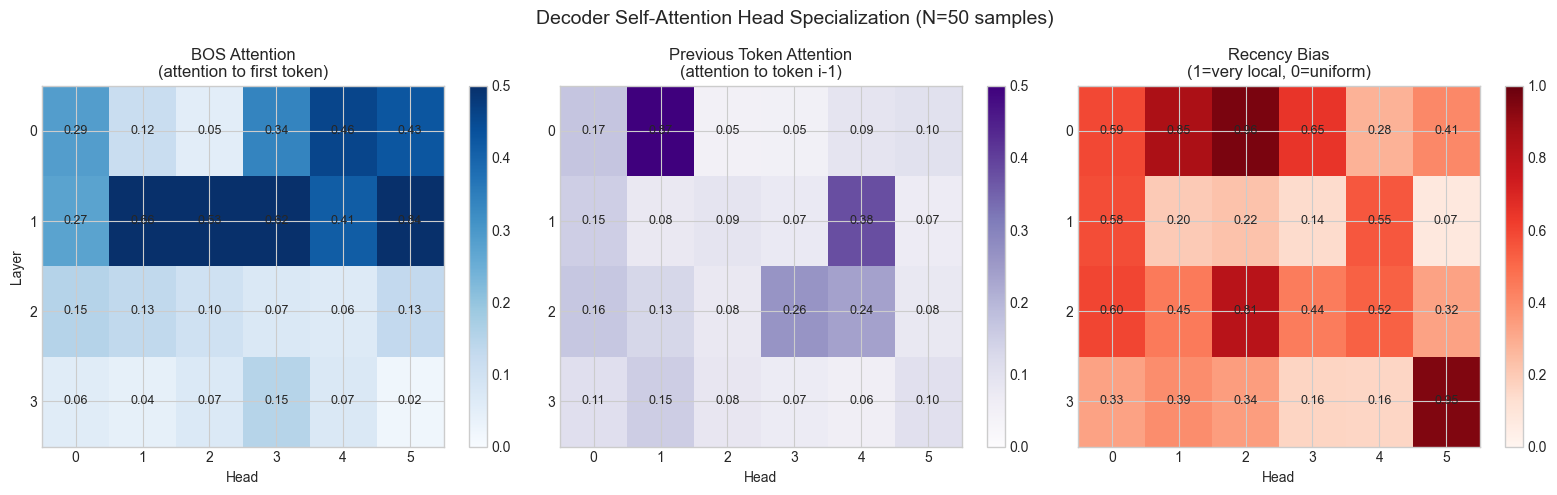


DECODER SELF-ATTENTION HEAD SUMMARY
BOS Attention = fraction attending to start token (context anchor)
Prev Token = attention to immediately previous token (local context)
Recency = how much attention is biased toward recent tokens
L0H0: MIXED                               | bos=0.29, prev=0.17, recency=0.59
L0H1: PREV-TOKEN + VERY-LOCAL             | bos=0.12, prev=0.87, recency=0.85
L0H2: VERY-LOCAL                          | bos=0.05, prev=0.05, recency=0.96
L0H3: BOS-ANCHOR                          | bos=0.34, prev=0.05, recency=0.65
L0H4: BOS-ANCHOR + DISTRIBUTED            | bos=0.46, prev=0.09, recency=0.28
L0H5: BOS-ANCHOR                          | bos=0.43, prev=0.10, recency=0.41
L1H0: MIXED                               | bos=0.27, prev=0.15, recency=0.58
L1H1: BOS-ANCHOR + DISTRIBUTED            | bos=0.66, prev=0.08, recency=0.20
L1H2: BOS-ANCHOR + DISTRIBUTED            | bos=0.53, prev=0.09, recency=0.22
L1H3: BOS-ANCHOR + DISTRIBUTED            | bos=0.62, prev=0.07, 

In [20]:
# Compute decoder self-attention metrics
print("Computing decoder self-attention metrics...")

# Metrics per head across samples
dec_bos_attention = np.zeros((N_SAMPLES, n_decoder_layers, n_decoder_heads))
dec_prev_token_attention = np.zeros((N_SAMPLES, n_decoder_layers, n_decoder_heads))
dec_recency_bias = np.zeros((N_SAMPLES, n_decoder_layers, n_decoder_heads))

for i in range(N_SAMPLES):
    self_attn = all_decoder_self_attn[i]  # [4, 6, dec_len, dec_len]
    dec_len = self_attn.shape[2]
    
    for l in range(n_decoder_layers):
        for h in range(n_decoder_heads):
            a = self_attn[l, h]  # [dec_len, dec_len]
            
            # BOS attention: how much attention goes to first token (position 0)
            # Average across all tokens (excluding first token itself)
            if dec_len > 1:
                bos_attn = a[1:, 0].mean().item()  # attention to position 0 from positions 1+
                dec_bos_attention[i, l, h] = bos_attn
            
            # Previous token attention: attention to position i-1 from position i
            # This is the sub-diagonal
            if dec_len > 1:
                prev_attn = torch.diag(a, diagonal=-1).mean().item()
                dec_prev_token_attention[i, l, h] = prev_attn
            
            # Recency bias: weighted average distance from diagonal
            # For causal attention, only lower triangle is valid
            # Higher = more local/recent attention
            if dec_len > 1:
                # Create distance matrix for causal attention
                positions = torch.arange(dec_len)
                # Distance from diagonal for query i, key j: i - j (only valid when j <= i)
                distance = positions.unsqueeze(1) - positions.unsqueeze(0)  # [dec_len, dec_len]
                # Mask upper triangle
                causal_mask = torch.tril(torch.ones(dec_len, dec_len))
                
                # Weighted mean distance
                weighted_dist = (a * distance * causal_mask).sum() / (a * causal_mask).sum()
                # Normalize: max distance in causal attention is (dec_len-1)
                max_dist = (dec_len - 1) / 2  # expected distance for uniform causal attention
                recency = 1 - (weighted_dist.item() / max_dist) if max_dist > 0 else 0
                dec_recency_bias[i, l, h] = max(0, min(1, recency))  # clamp to [0, 1]

# Average across samples
mean_bos_attn = dec_bos_attention.mean(axis=0)
mean_prev_token = dec_prev_token_attention.mean(axis=0)
mean_recency = dec_recency_bias.mean(axis=0)

# Plot decoder self-attention metrics dashboard
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# BOS attention
im1 = axes[0].imshow(mean_bos_attn, cmap='Blues', aspect='auto', vmin=0, vmax=0.5)
axes[0].set_title('BOS Attention\n(attention to first token)')
axes[0].set_xlabel('Head')
axes[0].set_ylabel('Layer')
for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        axes[0].text(h, l, f'{mean_bos_attn[l, h]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im1, ax=axes[0])

# Previous token attention
im2 = axes[1].imshow(mean_prev_token, cmap='Purples', aspect='auto', vmin=0, vmax=0.5)
axes[1].set_title('Previous Token Attention\n(attention to token i-1)')
axes[1].set_xlabel('Head')
for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        axes[1].text(h, l, f'{mean_prev_token[l, h]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im2, ax=axes[1])

# Recency bias
im3 = axes[2].imshow(mean_recency, cmap='Reds', aspect='auto', vmin=0, vmax=1)
axes[2].set_title('Recency Bias\n(1=very local, 0=uniform)')
axes[2].set_xlabel('Head')
for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        axes[2].text(h, l, f'{mean_recency[l, h]:.2f}', ha='center', va='center', fontsize=9)
plt.colorbar(im3, ax=axes[2])

for ax in axes:
    ax.set_xticks(range(n_decoder_heads))
    ax.set_yticks(range(n_decoder_layers))

fig.suptitle(f'Decoder Self-Attention Head Specialization (N={N_SAMPLES} samples)', fontsize=14)
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*70)
print("DECODER SELF-ATTENTION HEAD SUMMARY")
print("="*70)
print("BOS Attention = fraction attending to start token (context anchor)")
print("Prev Token = attention to immediately previous token (local context)")
print("Recency = how much attention is biased toward recent tokens")
print("="*70)

for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        bos = mean_bos_attn[l, h]
        prev = mean_prev_token[l, h]
        rec = mean_recency[l, h]
        
        tags = []
        if bos > 0.3:
            tags.append("BOS-ANCHOR")
        if prev > 0.3:
            tags.append("PREV-TOKEN")
        if rec > 0.7:
            tags.append("VERY-LOCAL")
        elif rec < 0.4:
            tags.append("DISTRIBUTED")
        if not tags:
            tags.append("MIXED")
        
        print(f"L{l}H{h}: {' + '.join(tags):35s} | bos={bos:.2f}, prev={prev:.2f}, recency={rec:.2f}")

Computing mean decoder self-attention patterns across samples...
Max decoder length: 48 tokens


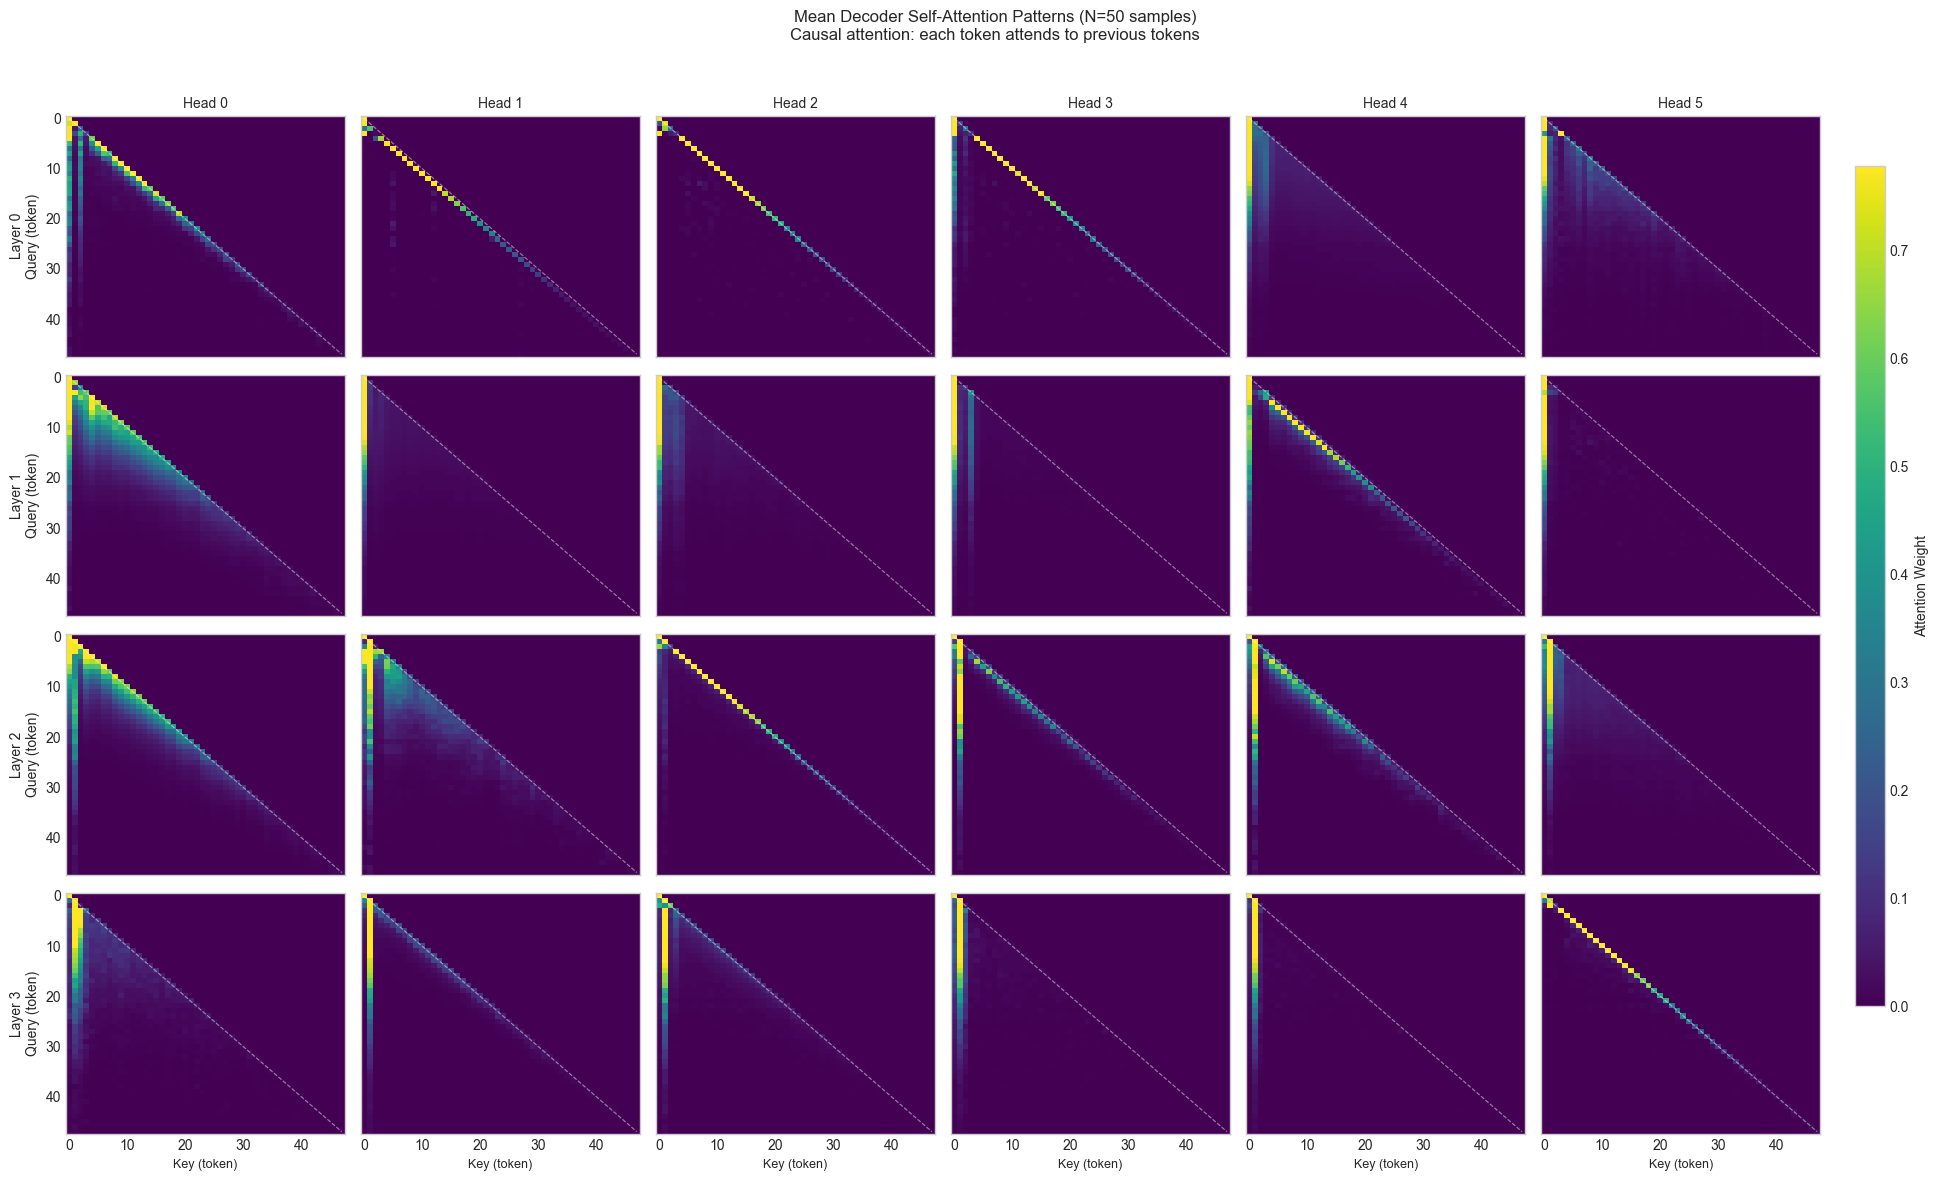


Notable patterns:
  - Vertical stripe at column 0 = BOS attention (attending to start token)
  - Bright sub-diagonal = previous token attention
  - L0H1: Strong previous-token pattern (bright sub-diagonal)
  - L1H5: Strong BOS attention (bright first column)
  - L3: More distributed patterns (global context integration)


In [21]:
# Compute and visualize MEAN decoder self-attention patterns across all samples
# Handle variable decoder lengths by padding

print("Computing mean decoder self-attention patterns across samples...")

# Find max decoder length
max_dec_len = max(a.shape[2] for a in all_decoder_self_attn)
print(f"Max decoder length: {max_dec_len} tokens")

# Pad all self-attention patterns to same size and average
# Shape: [n_layers, n_heads, max_dec_len, max_dec_len]
padded_self_attn = torch.zeros(N_SAMPLES, n_decoder_layers, n_decoder_heads, max_dec_len, max_dec_len)
for i, sa in enumerate(all_decoder_self_attn):
    dec_len = sa.shape[2]
    padded_self_attn[i, :, :, :dec_len, :dec_len] = sa

# Mean across samples
mean_self_attn = padded_self_attn.mean(dim=0)  # [4, 6, max_dec_len, max_dec_len]

# Plot mean self-attention patterns
fig, axes = plt.subplots(n_decoder_layers, n_decoder_heads, figsize=(20, 12))
fig.suptitle(f'Mean Decoder Self-Attention Patterns (N={N_SAMPLES} samples)\n'
             f'Causal attention: each token attends to previous tokens', fontsize=12)

for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        ax = axes[l, h]
        attn = mean_self_attn[l, h].numpy()
        
        # Clip to 99th percentile for better contrast
        vmax = np.percentile(attn[attn > 0], 99) if (attn > 0).any() else 0.1
        
        im = ax.imshow(attn, cmap='viridis', aspect='auto',
                       vmin=0, vmax=vmax)
        
        # Diagonal reference
        ax.plot([0, max_dec_len-1], [0, max_dec_len-1], 'w--', alpha=0.5, linewidth=0.8)
        
        if l == 0:
            ax.set_title(f'Head {h}', fontsize=10)
        if h == 0:
            ax.set_ylabel(f'Layer {l}\nQuery (token)', fontsize=10)
        if l == n_decoder_layers - 1:
            ax.set_xlabel('Key (token)', fontsize=9)
        
        ax.grid(False)
        if l != n_decoder_layers - 1:
            ax.set_xticklabels([])
        if h != 0:
            ax.set_yticklabels([])

plt.tight_layout(rect=[0, 0, 0.92, 0.96])
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Attention Weight', fontsize=10)

plt.show()

print("\nNotable patterns:")
print("  - Vertical stripe at column 0 = BOS attention (attending to start token)")
print("  - Bright sub-diagonal = previous token attention")
print("  - L0H1: Strong previous-token pattern (bright sub-diagonal)")
print("  - L1H5: Strong BOS attention (bright first column)")
print("  - L3: More distributed patterns (global context integration)")

### 2c. Combined Decoder Dashboard

Summary view comparing all decoder heads across both attention types.

COMBINED DECODER HEAD SPECIALIZATION

Cross-attention metrics (decoder -> encoder):
  - Speech Focus: attention within speech region
  - Sharpness: how peaked the attention distribution is
  - Monotonicity: left-to-right temporal alignment

Self-attention metrics (decoder -> decoder):
  - BOS: attention to start token
  - Prev: attention to previous token
  - Recency: bias toward recent tokens


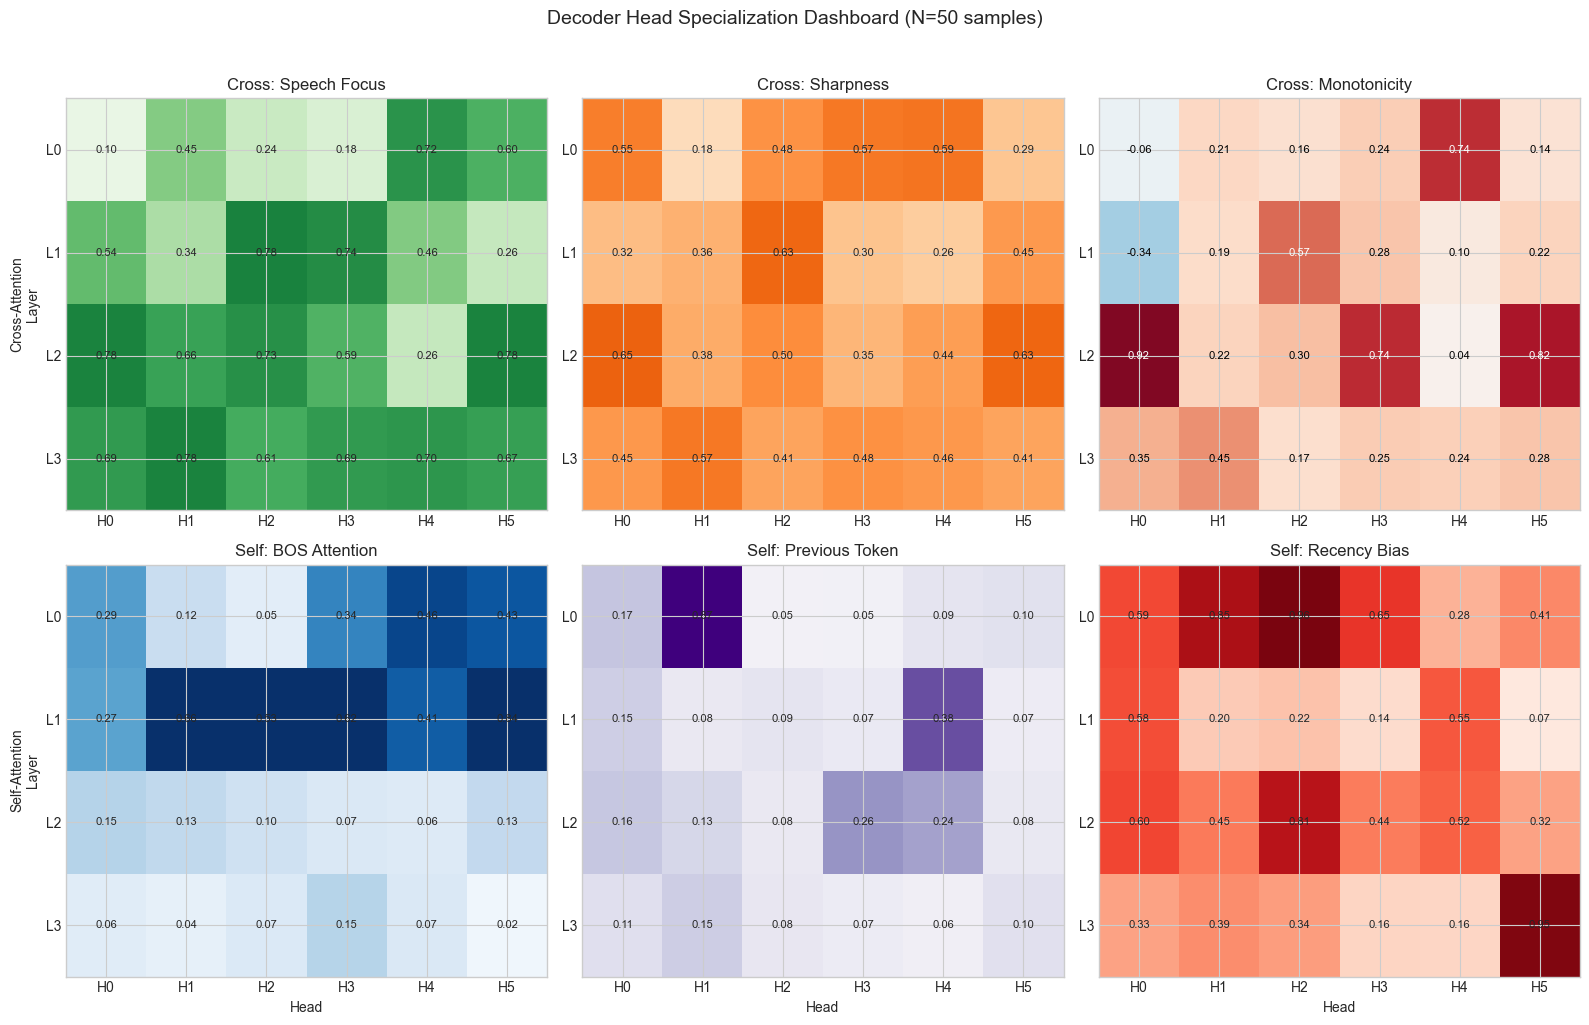


HEAD CLASSIFICATION TABLE
Layer.Head Cross-Attn Type           Self-Attn Type           
----------------------------------------------------------------------
L0H0       PADDING                   BOS-ANCHOR               
L0H1       PADDING                   PREV-TOKEN+LOCAL         
L0H2       PADDING                   LOCAL                    
L0H3       PADDING                   BOS-ANCHOR               
L0H4       ALIGNER                   BOS-ANCHOR+GLOBAL        
L0H5       DIFFUSE                   BOS-ANCHOR               
L1H0       DIFFUSE                   BOS-ANCHOR               
L1H1       PADDING                   BOS-ANCHOR+GLOBAL        
L1H2       SHARP                     BOS-ANCHOR+GLOBAL        
L1H3       DIFFUSE                   BOS-ANCHOR+GLOBAL        
L1H4       PADDING                   BOS-ANCHOR+PREV-TOKEN    
L1H5       PADDING                   BOS-ANCHOR+GLOBAL        
L2H0       ALIGNER                   MIXED                    
L2H1       DIFFUSE  

In [22]:
# Combined decoder head specialization summary
print("="*70)
print("COMBINED DECODER HEAD SPECIALIZATION")
print("="*70)
print("\nCross-attention metrics (decoder -> encoder):")
print("  - Speech Focus: attention within speech region")
print("  - Sharpness: how peaked the attention distribution is")
print("  - Monotonicity: left-to-right temporal alignment")
print("\nSelf-attention metrics (decoder -> decoder):")
print("  - BOS: attention to start token")
print("  - Prev: attention to previous token")
print("  - Recency: bias toward recent tokens")
print("="*70)

# Create combined visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle(f'Decoder Head Specialization Dashboard (N={N_SAMPLES} samples)', fontsize=14, y=1.02)

# Row 1: Cross-attention
axes[0, 0].imshow(mean_speech_focus, cmap='Greens', aspect='auto', vmin=0, vmax=1)
axes[0, 0].set_title('Cross: Speech Focus')
for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        axes[0, 0].text(h, l, f'{mean_speech_focus[l, h]:.2f}', ha='center', va='center', fontsize=8)

axes[0, 1].imshow(mean_sharpness, cmap='Oranges', aspect='auto', vmin=0, vmax=1)
axes[0, 1].set_title('Cross: Sharpness')
for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        axes[0, 1].text(h, l, f'{mean_sharpness[l, h]:.2f}', ha='center', va='center', fontsize=8)

axes[0, 2].imshow(mean_monotonicity, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[0, 2].set_title('Cross: Monotonicity')
for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        axes[0, 2].text(h, l, f'{mean_monotonicity[l, h]:.2f}', ha='center', va='center', fontsize=8,
                       color='white' if abs(mean_monotonicity[l, h]) > 0.5 else 'black')

# Row 2: Self-attention
axes[1, 0].imshow(mean_bos_attn, cmap='Blues', aspect='auto', vmin=0, vmax=0.5)
axes[1, 0].set_title('Self: BOS Attention')
for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        axes[1, 0].text(h, l, f'{mean_bos_attn[l, h]:.2f}', ha='center', va='center', fontsize=8)

axes[1, 1].imshow(mean_prev_token, cmap='Purples', aspect='auto', vmin=0, vmax=0.5)
axes[1, 1].set_title('Self: Previous Token')
for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        axes[1, 1].text(h, l, f'{mean_prev_token[l, h]:.2f}', ha='center', va='center', fontsize=8)

axes[1, 2].imshow(mean_recency, cmap='Reds', aspect='auto', vmin=0, vmax=1)
axes[1, 2].set_title('Self: Recency Bias')
for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        axes[1, 2].text(h, l, f'{mean_recency[l, h]:.2f}', ha='center', va='center', fontsize=8)

for ax in axes.flat:
    ax.set_xticks(range(n_decoder_heads))
    ax.set_yticks(range(n_decoder_layers))
    ax.set_xticklabels([f'H{h}' for h in range(n_decoder_heads)])
    ax.set_yticklabels([f'L{l}' for l in range(n_decoder_layers)])

axes[0, 0].set_ylabel('Cross-Attention\nLayer')
axes[1, 0].set_ylabel('Self-Attention\nLayer')
for ax in axes[1]:
    ax.set_xlabel('Head')

plt.tight_layout()
plt.show()

# Print combined classification
print("\n" + "="*70)
print("HEAD CLASSIFICATION TABLE")
print("="*70)
print(f"{'Layer.Head':<10} {'Cross-Attn Type':<25} {'Self-Attn Type':<25}")
print("-"*70)

for l in range(n_decoder_layers):
    for h in range(n_decoder_heads):
        # Cross-attention classification
        sf, sh, mo = mean_speech_focus[l, h], mean_sharpness[l, h], mean_monotonicity[l, h]
        cross_tags = []
        if mo > 0.7 and sh > 0.5:
            cross_tags.append("ALIGNER")
        elif sf < 0.5:
            cross_tags.append("PADDING")
        elif sh > 0.6:
            cross_tags.append("SHARP")
        else:
            cross_tags.append("DIFFUSE")
        
        # Self-attention classification
        bos, prev, rec = mean_bos_attn[l, h], mean_prev_token[l, h], mean_recency[l, h]
        self_tags = []
        if bos > 0.25:
            self_tags.append("BOS-ANCHOR")
        if prev > 0.25:
            self_tags.append("PREV-TOKEN")
        if rec > 0.7:
            self_tags.append("LOCAL")
        elif rec < 0.4:
            self_tags.append("GLOBAL")
        if not self_tags:
            self_tags.append("MIXED")
        
        print(f"L{l}H{h:<7} {'+'.join(cross_tags):<25} {'+'.join(self_tags):<25}")

## Summary

### Encoder Attention
- **Highly local**: Most encoder heads show strong diagonal patterns (locality > 0.85)
- **Speech retention**: Heads keep attention within speech region (retention > 0.8 typically)
- **Energy correlation**: Some heads track acoustic energy (attend more to speech vs silence)
- **Padding confound**: ~85% of each sample is padding; metrics designed to handle this

### Decoder Cross-Attention
- **Alignment heads**: High monotonicity + sharpness = tracks audio position as tokens generated
- **Speech focus**: Most heads focus on speech region rather than padding
- **Sharpness varies**: Some heads have peaked attention (precise alignment), others diffuse

### Decoder Self-Attention
- **BOS anchoring**: Some heads attend heavily to start-of-sequence token
- **Previous token**: Some heads focus on immediately preceding token (local context)
- **Recency patterns**: Mix of local (recent tokens) and distributed attention

### Key Findings
1. **Encoder Layer 0** is highly local - primarily adjacent-frame attention
2. **Cross-attention** shows monotonic alignment patterns in several heads
3. **Decoder self-attention** shows mix of positional patterns (BOS, previous token, distributed)
4. **Padding confound** is real but our metrics account for it properly